# TOCE RIVER BASIN

13/10/2021

In this notebook results of different feature selections are compared for the Candoglia basin (of which we have around 18 years of data)

Input data is clipped from ERA5 metereological reanalysis quantile mapped and downscaled.

10 days average (for the previous year) of pecipitation, temperature and potential evapotranspiration are selected as input.


The settings are the following:

    A) 180 features are selected with PCA, the same numeriosity as setting C) ;

    B) 36 features are selectedwith PCA, the same numeriosity as setting D) ;
        
    C) metereological inputs spatial statistics are used as input: mean, the 5th, 25th, 75th and 95th quantiles are selected.
        
    D) metereological inputs are spatially averaged.




import sys
sys.path.append('/time_unit')

In [51]:
import sys, importlib
importlib.reload(sys.modules['nested_CV'])


<module 'nested_CV' from 'C:\\Users\\mmazzolini\\OneDrive - Scientific Network South Tyrol\\Documents\\conda\\Runoff_prediction\\nested_CV.py'>

In [1]:
from base_f import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from cross_validation_f_gamma import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from cross_validation_f_gamma import evaluate_prediction, plot_prediction, plot_anomalies
from cross_validation_f_gamma import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from cross_validation_f_gamma import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

ModuleNotFoundError: No module named 'sf_runoff'

In [2]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'

daily_input = pd.read_csv(path+'CANDOGLIA_TOCE_2000_2019.csv', index_col=0, parse_dates=True)

daily_input_TPE = spatial_avg_daily_input(daily_input)

daily_input_stat = spatial_stats_daily_input(daily_input)

In [3]:
daily_input.shape[1]

302

In [4]:
var_x=np.var(a=np.array(daily_input),where=np.logical_not(np.isnan(np.array(daily_input))))
gamma_scale= 1/var_x/(daily_input.shape[1]-1)

In [4]:
gamma_scale

1.734370376698777e-07

In [5]:
t_unit=30


#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-1,3,6)
epsilon_range=np.logspace(-1, 1, 6)
gamma_range=np.logspace(-7,-4, 8)

#n_range = [17, 50, 200]
components_range = [5*4*36]
components_range = [int(5*4*30/t_unit*12)]

#do not enlarge t_range for now
t_range=[12]
t_length=t_range[0]
n_splits=5
test_size=365

In [7]:
gamma_scale= 1/var_x/(components_range)
gamma_scale

array([1.06219754e-09])

# A) PCA+SVR

### TRAIN A PCA+SVR MODEL 

In [9]:
t_unit=30


#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-1,3,6)
epsilon_range=np.logspace(-3, -1, 5)
gamma_range=np.logspace(-5,-2, 8)

#n_range = [17, 50, 200]
components_range = [5*4*36]
components_range = [int(5*4*30/t_unit*12)]

#do not enlarge t_range for now
t_range=[12]
t_length=t_range[0]
n_splits=5
test_size=365

Fitting 1 folds for each of 240 candidates, totalling 240 fits
Fitting 1 folds for each of 240 candidates, totalling 240 fits
Fitting 1 folds for each of 240 candidates, totalling 240 fits
Fitting 1 folds for each of 240 candidates, totalling 240 fits
Fitting 1 folds for each of 240 candidates, totalling 240 fits

C=0.6309573444801934
eps=0.1
gamma=0.00019306977288832496
n=240


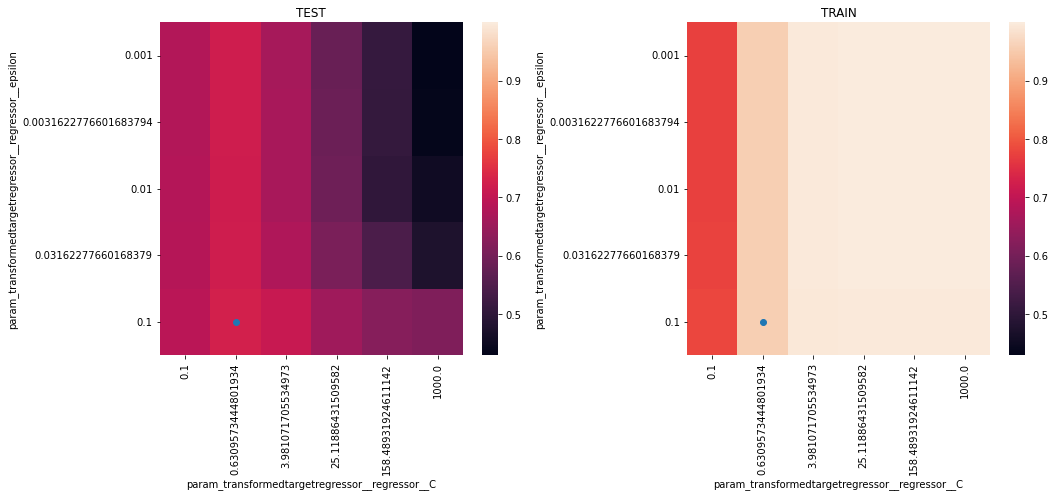

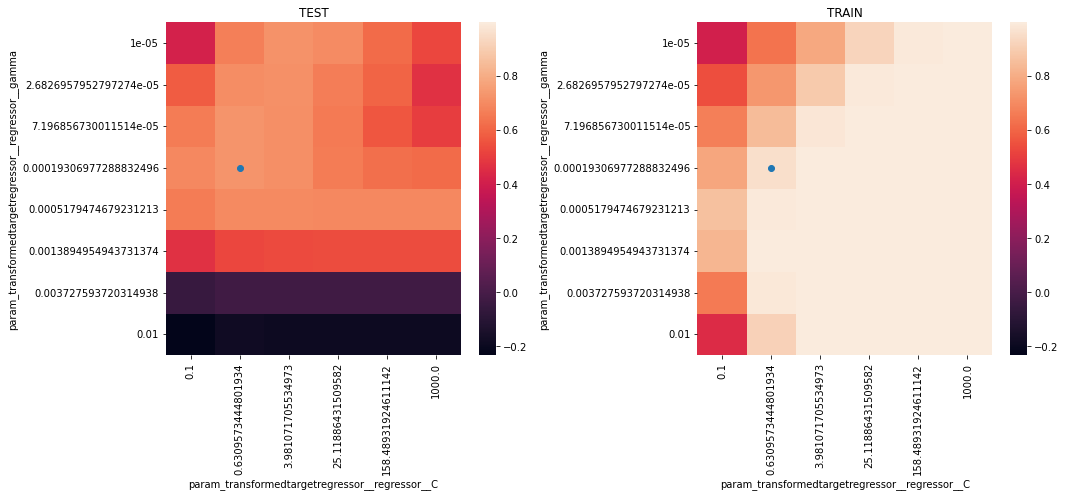

In [10]:
C,eps,gamma,n=SVR_PCA_nested_CV_gridsearch(daily_input, C_range,  epsilon_range,gamma_range, components_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')
print(f'gamma={gamma}')
print(f'n={n}')

C=0.5994842503189409
eps=0.005623413251903491
n=720

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [11]:
radius_for_ensemble = 1
predictions = nested_CV_PCA_SVR_predict(daily_input, C, eps,gamma, n, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

predictions=pd.read_csv('tial.csv',date_parser=True)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

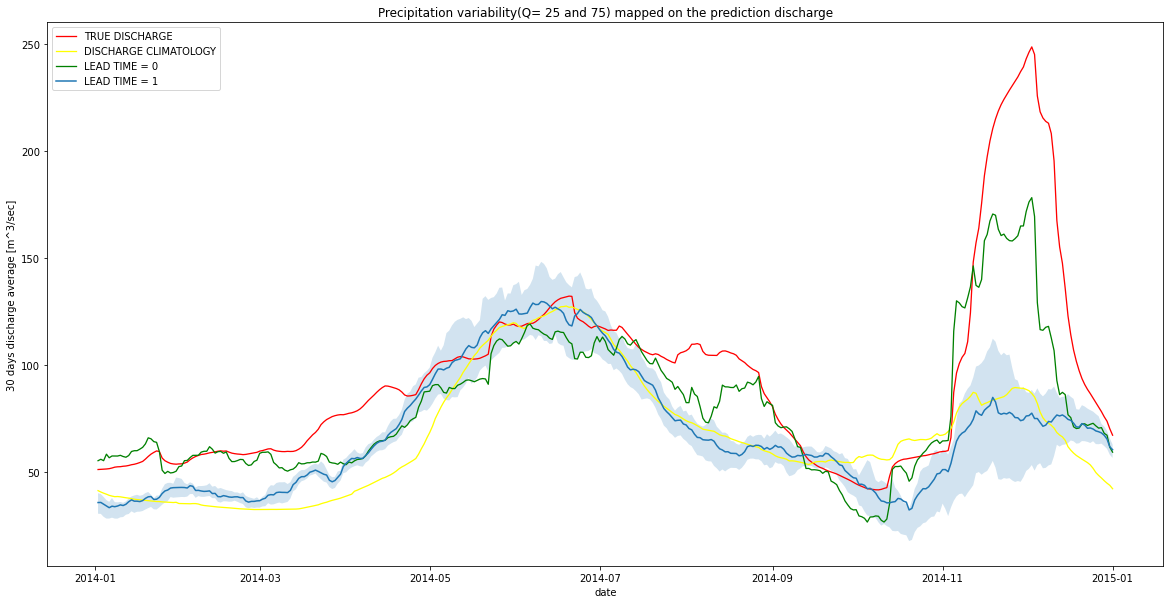

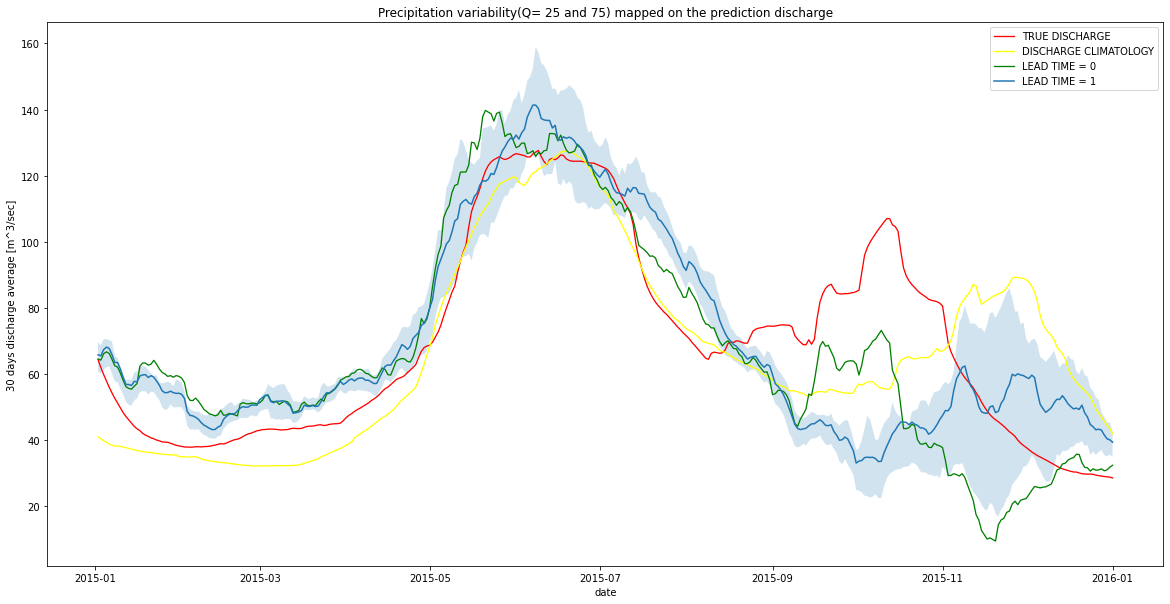

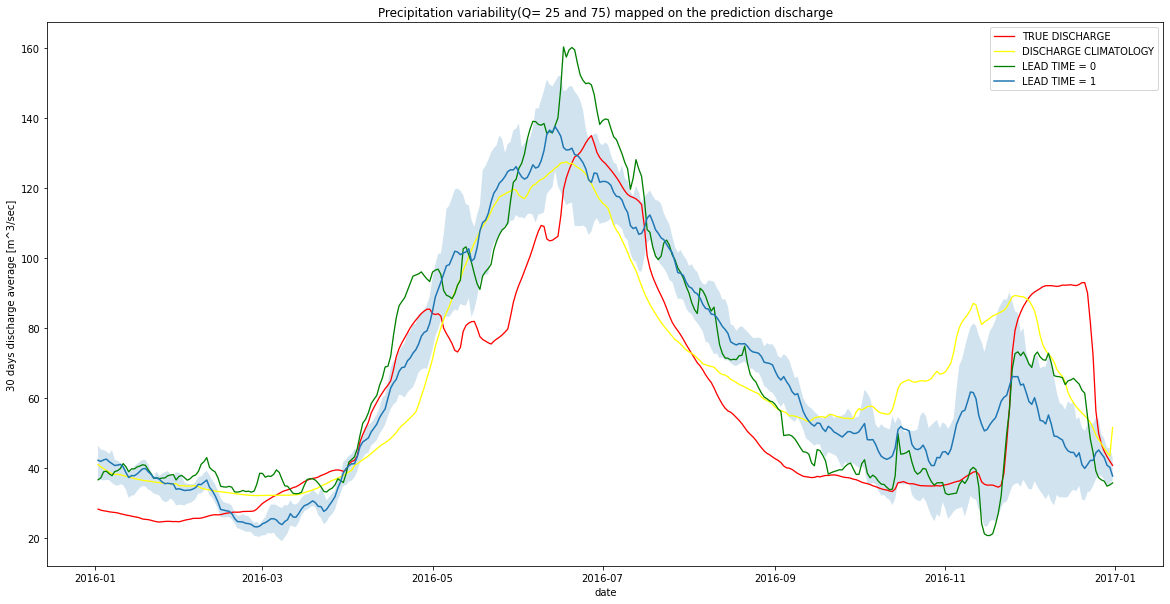

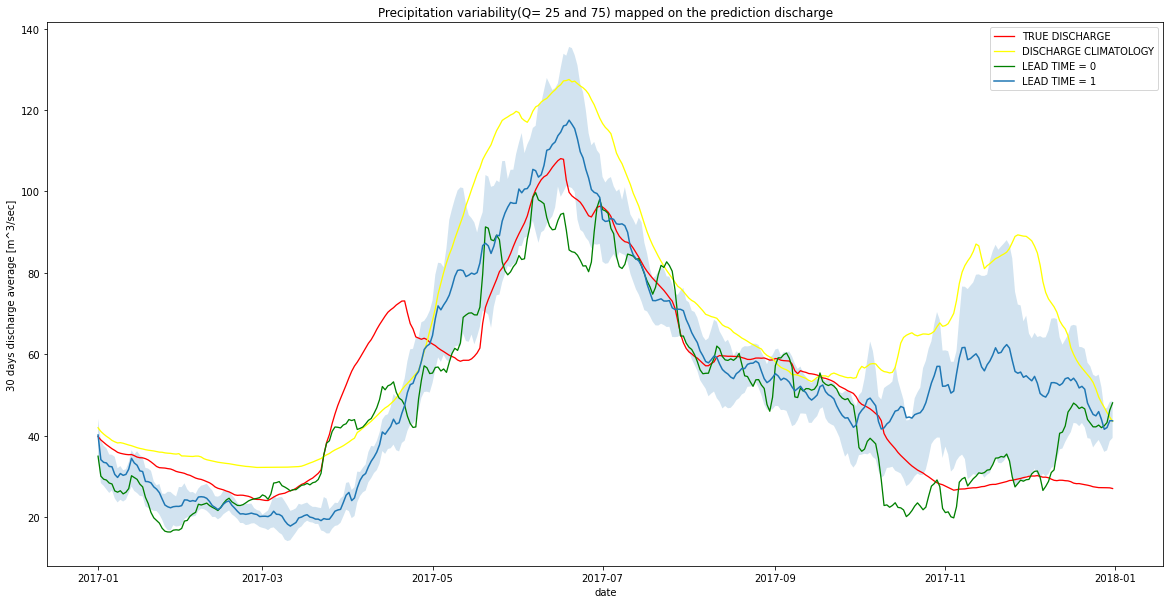

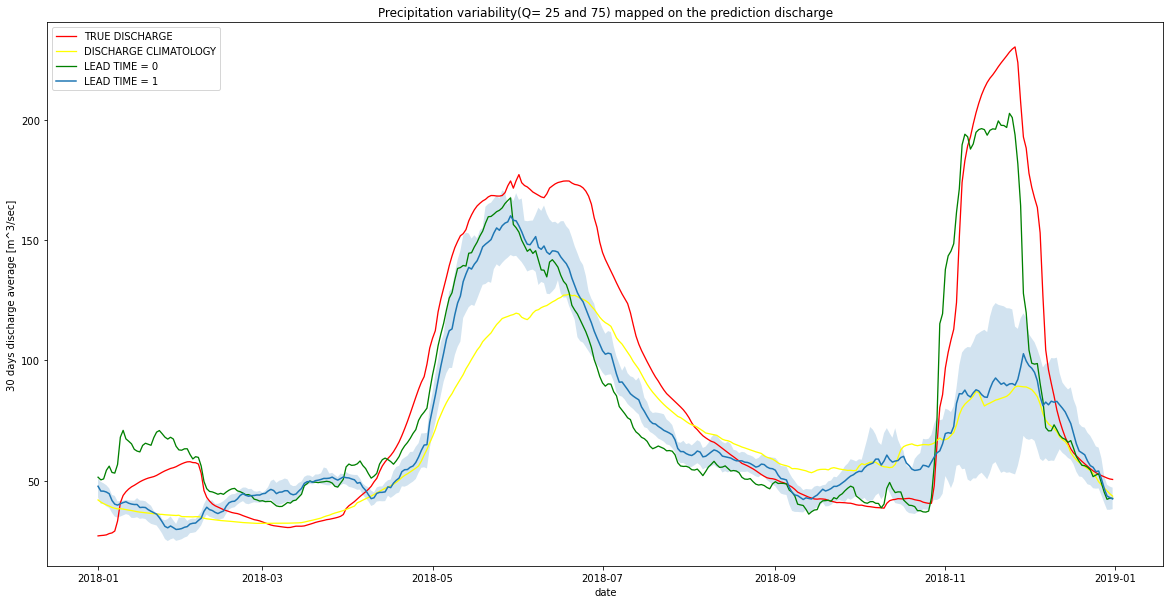

In [12]:
plot_prediction(predictions)

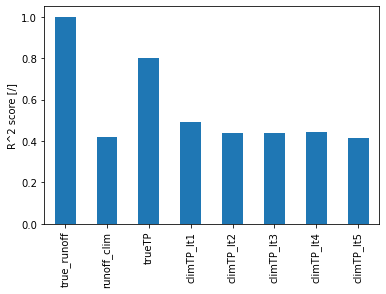

In [13]:
r2_PCA180 = evaluate_prediction(predictions)
#r2_PCA = evaluate_prediction(predictions.iloc[:,1:])

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [14]:
predictions_for_clim = classic_CV_PCA_SVR_predict(daily_input, C, eps,gamma, n, t_length,t_unit, n_splits)

In [15]:
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index


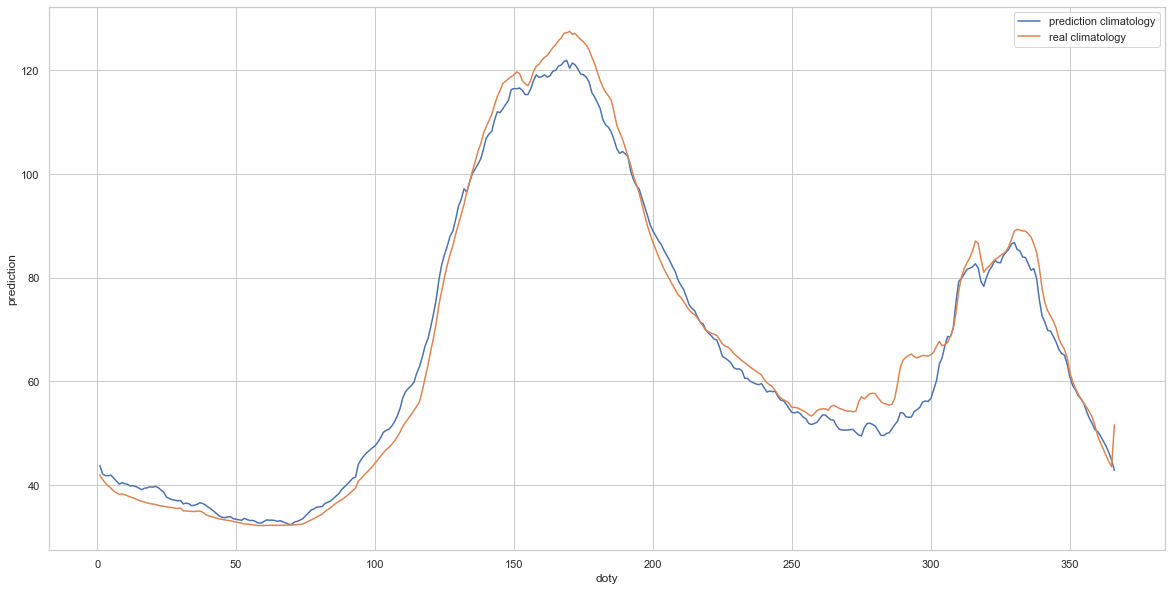

In [16]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

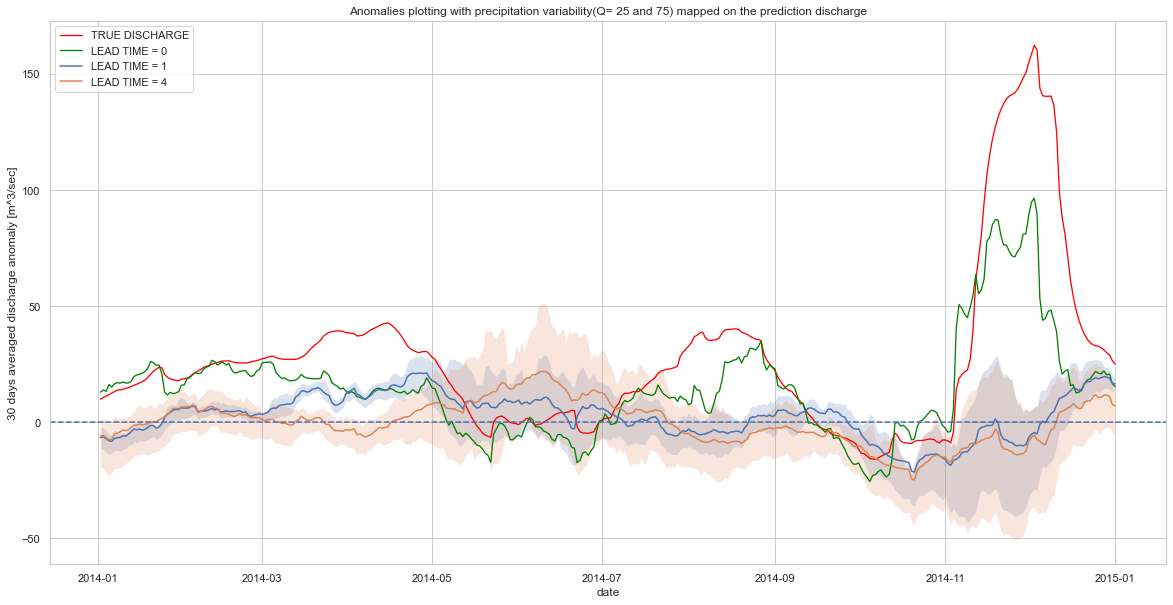

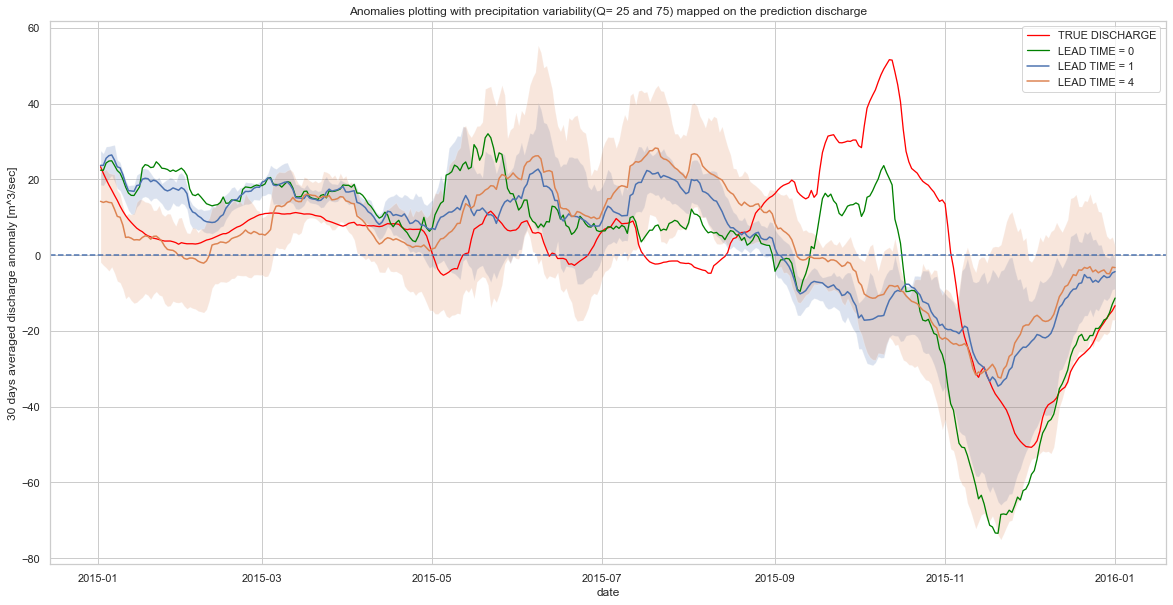

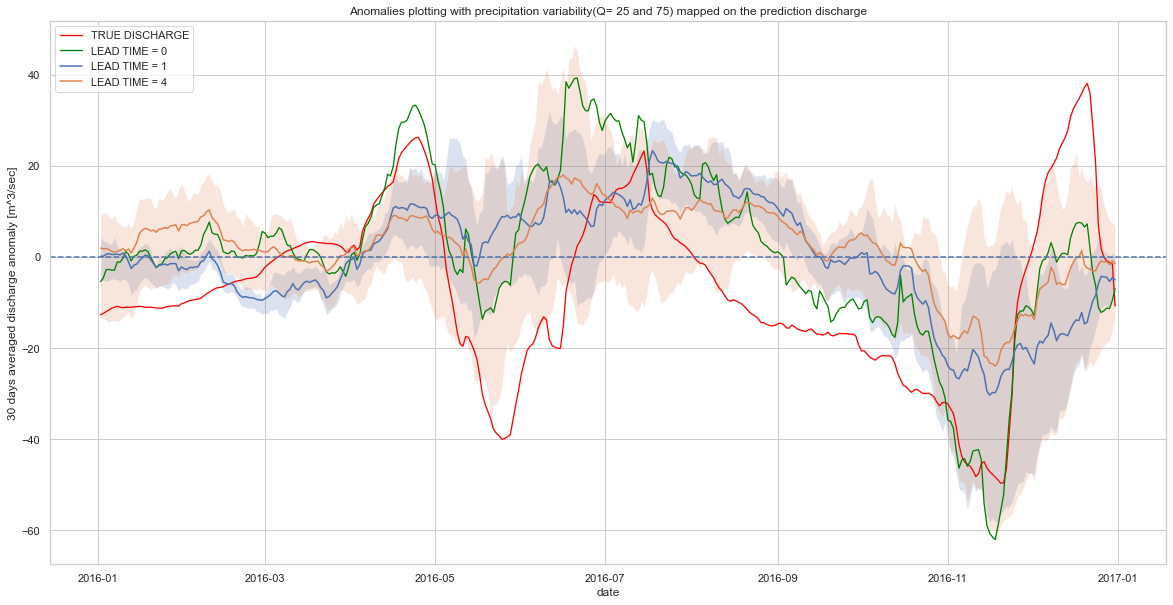

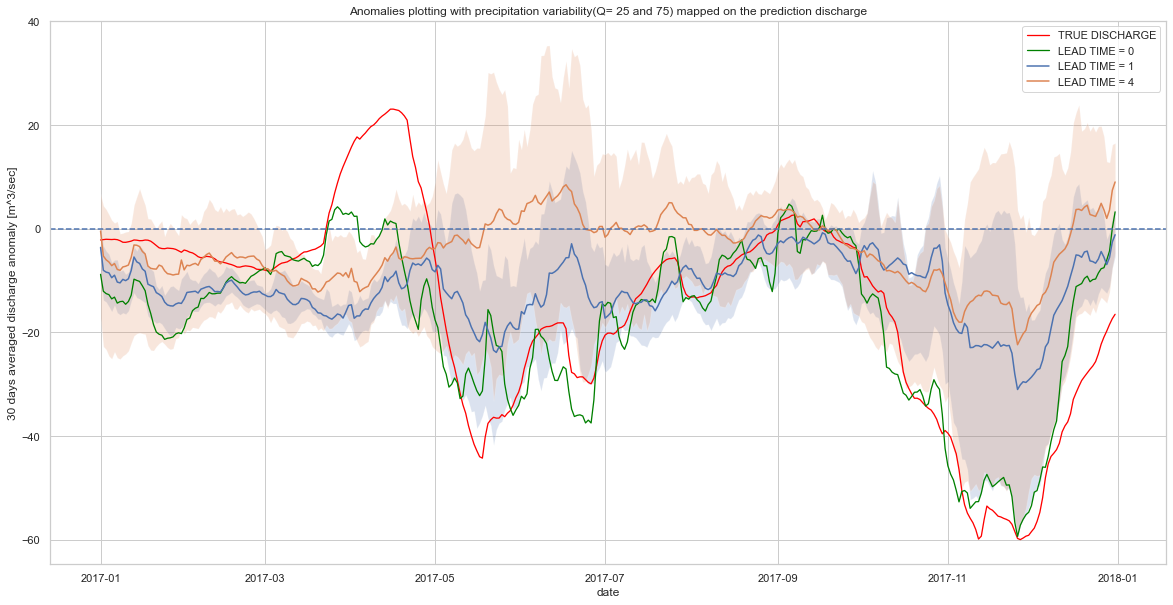

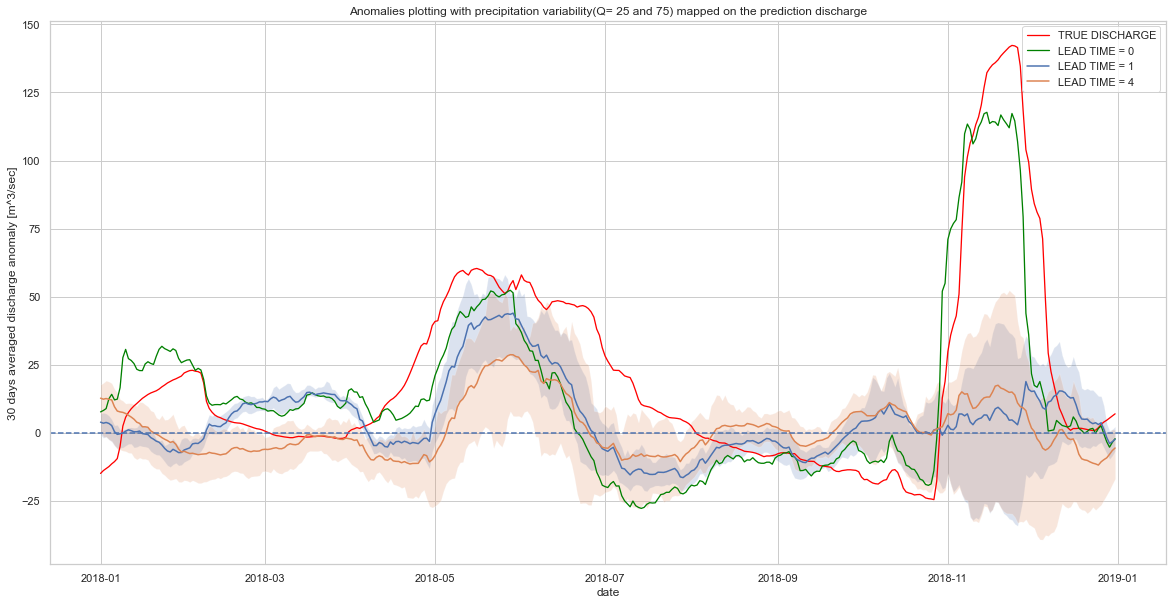

In [17]:
a=compute_anomalies(climatologies, predictions)
a['split']=predictions.split
plot_anomalies(a)

## B) PCA+SVR 

### TRAIN A PCA+SVR MODEL 

In [18]:
t_unit=30


#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-2,1,10)
epsilon_range=np.logspace(-4, -2, 5)
gamma_range=np.logspace(-5,-2, 6)

#n_range = [17, 50, 200]
#components_range = [5*4*36]
components_range2 = [int(4*30/t_unit*12)]

#do not enlarge t_range for now
t_range=[12]
t_length=t_range[0]
n_splits=5
test_size=365

Fitting 1 folds for each of 300 candidates, totalling 300 fits
Fitting 1 folds for each of 300 candidates, totalling 300 fits
Fitting 1 folds for each of 300 candidates, totalling 300 fits
Fitting 1 folds for each of 300 candidates, totalling 300 fits
Fitting 1 folds for each of 300 candidates, totalling 300 fits

C2=4.6415888336127775
epsilon2=0.01
gamma2=3.9810717055349695e-05
n2=48


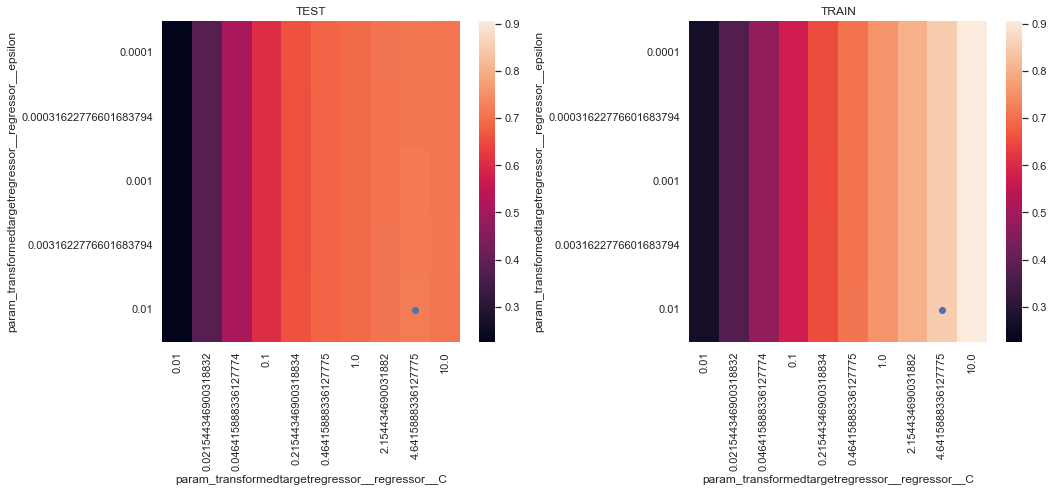

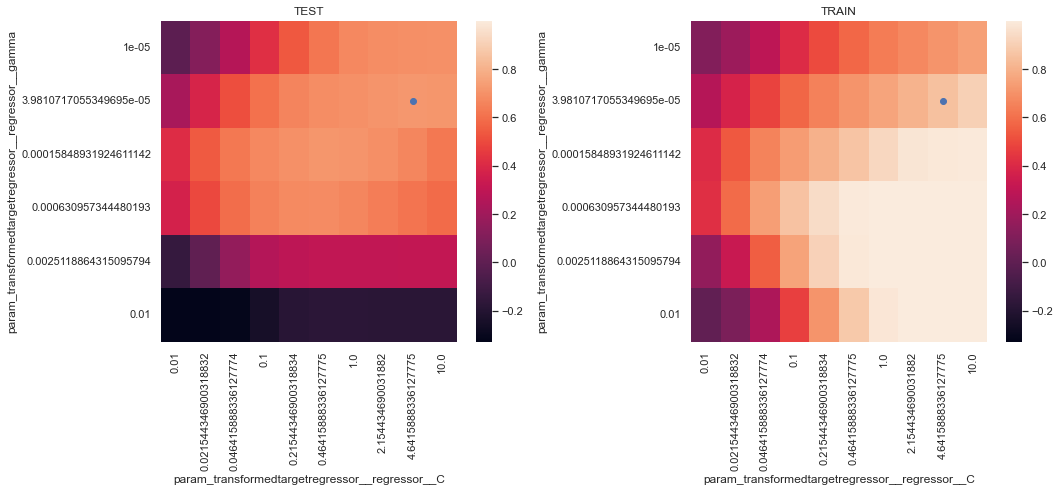

In [19]:
C2,eps2,gamma2,n2=SVR_PCA_nested_CV_gridsearch(daily_input, C_range,  epsilon_range,gamma_range, components_range2, t_range,t_unit,n_splits,test_size)
print(f'C2={C2}')
print(f'epsilon2={eps2}')
print(f'gamma2={gamma2}')
print(f'n2={n2}')

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [73]:
radius_for_ensemble = 1
predictions2 = nested_CV_PCA_SVR_predict(daily_input, C2, eps2,gamma2, n2, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

predictions=pd.read_csv('tial.csv',date_parser=True)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

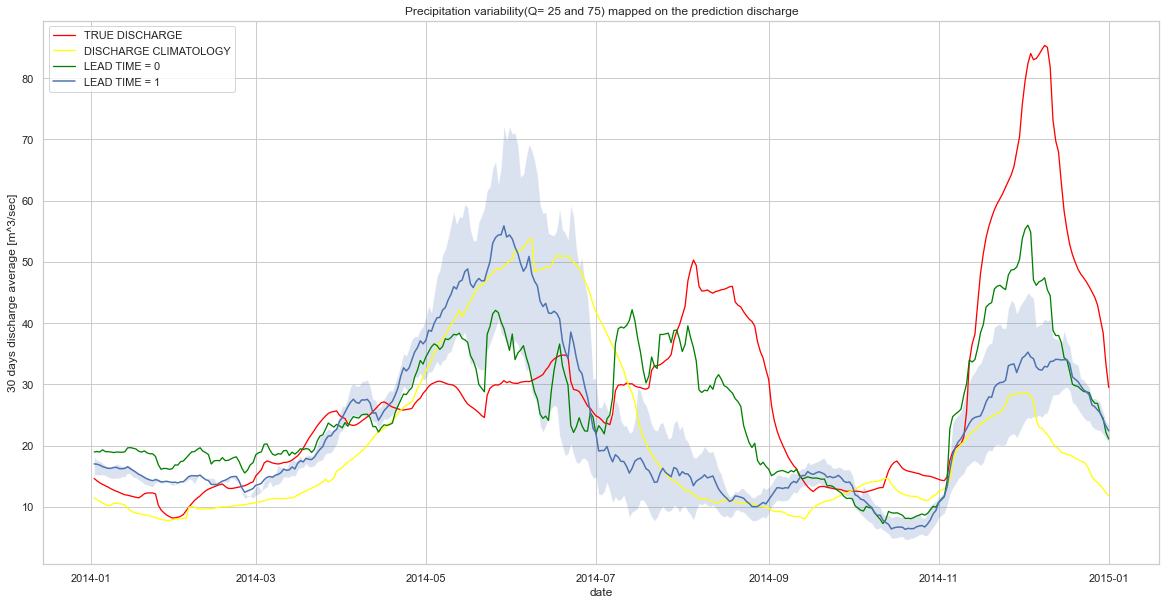

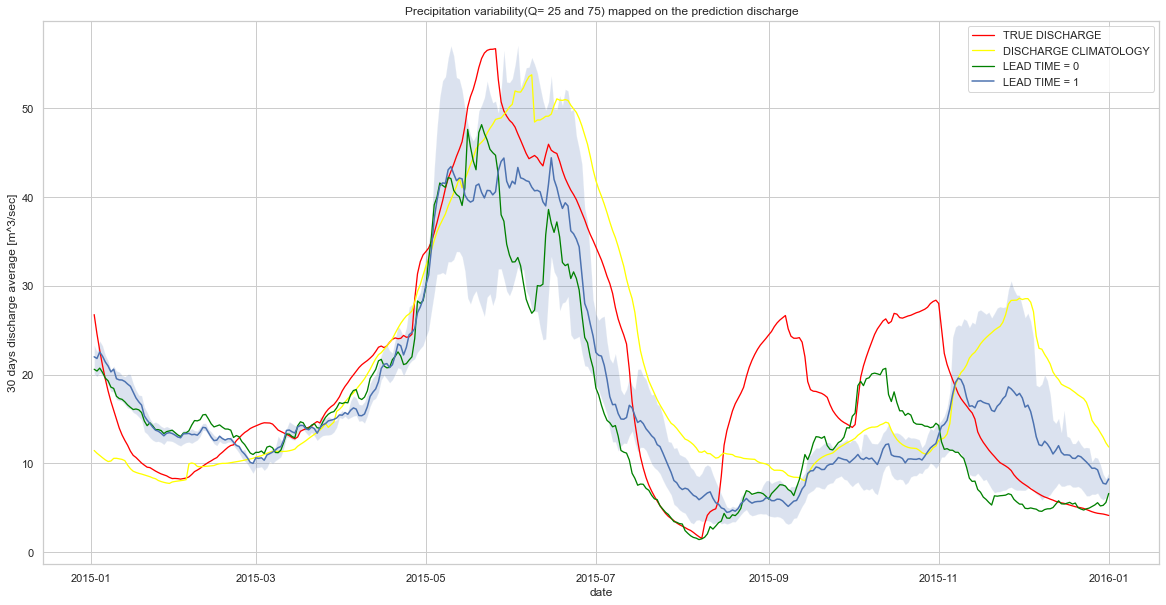

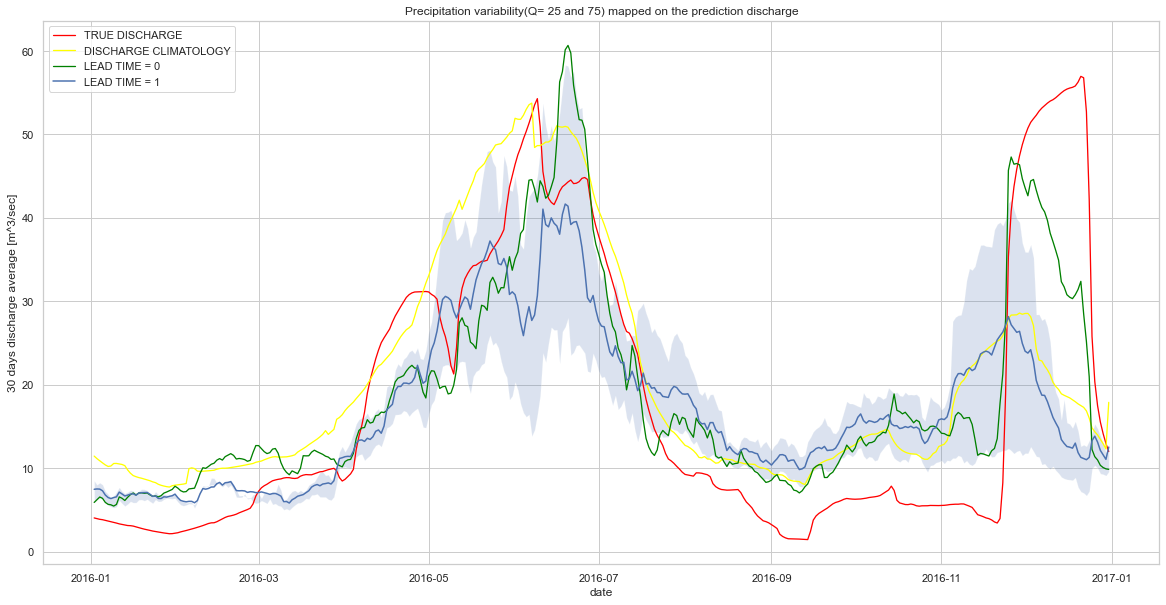

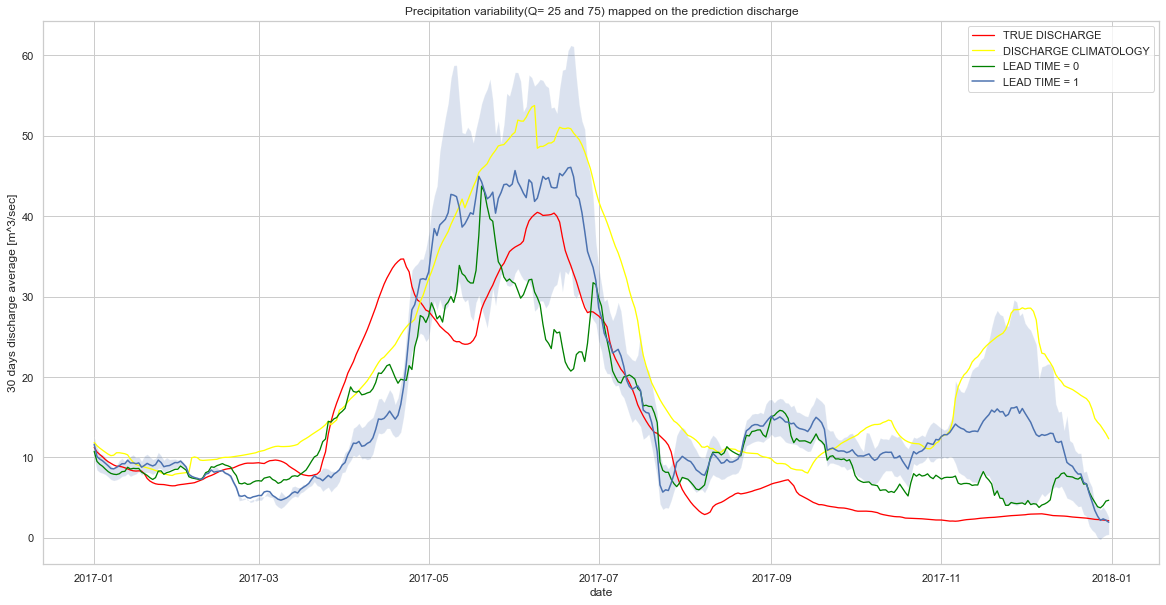

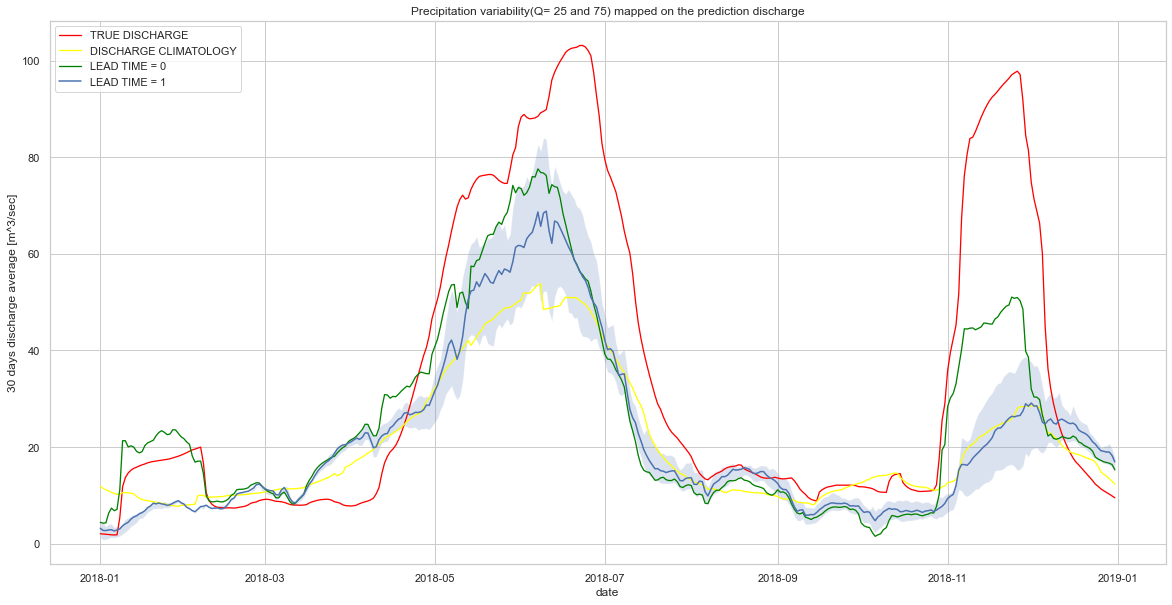

In [74]:
plot_prediction(predictions2)

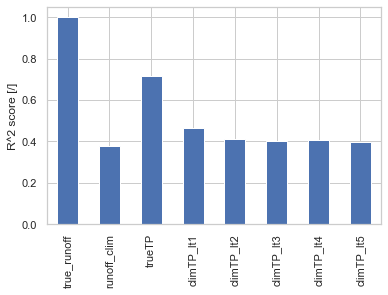

In [75]:
r2_PCA36 = evaluate_prediction(predictions2)
#r2_PCA = evaluate_prediction(predictions.iloc[:,1:])

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

predictions_for_clim2 = classic_CV_PCA_SVR_predict(daily_input, C2, eps2, n2, 12, n_splits)
climatologies2 =predictions_for_clim2.groupby(by=predictions_for_clim2.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies2['doty']=climatologies2.index


In [76]:
climatologies2=climatologies

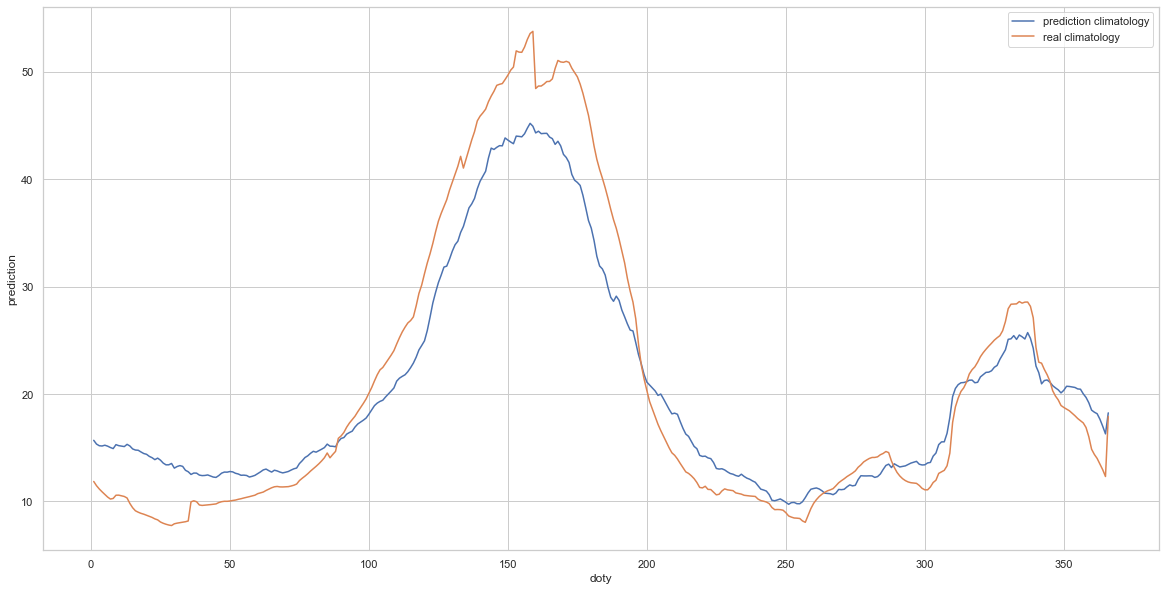

In [77]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies2,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies2,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

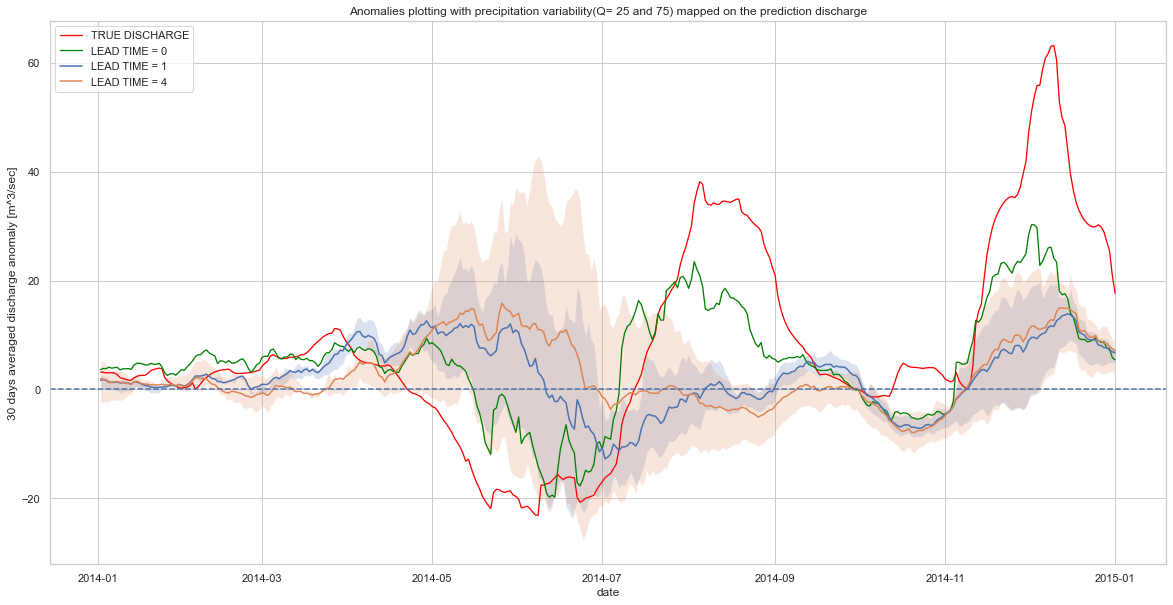

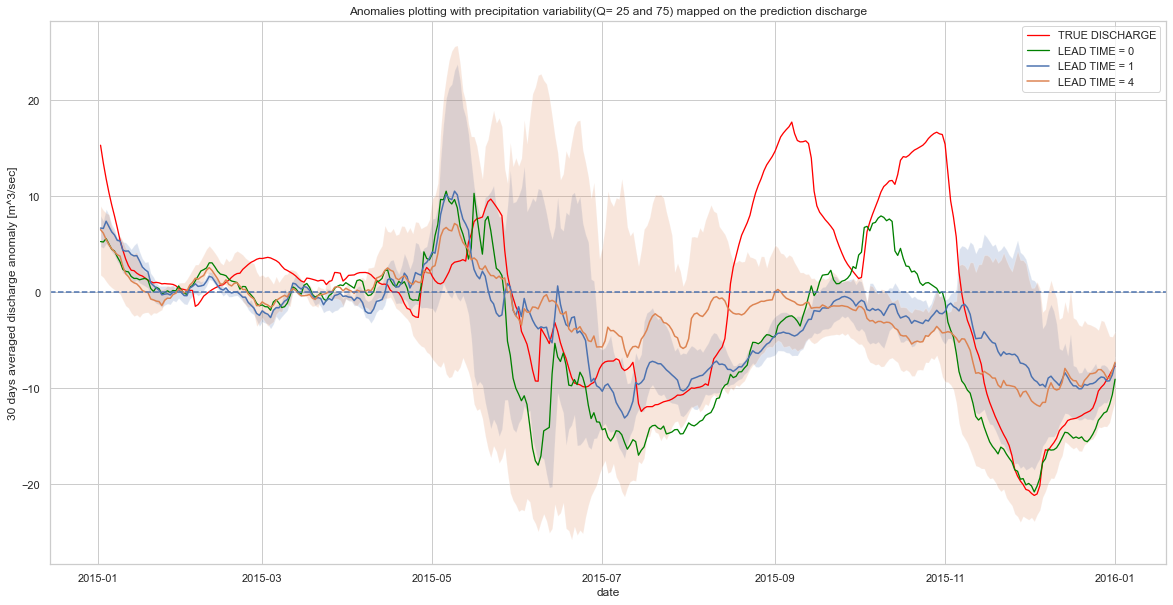

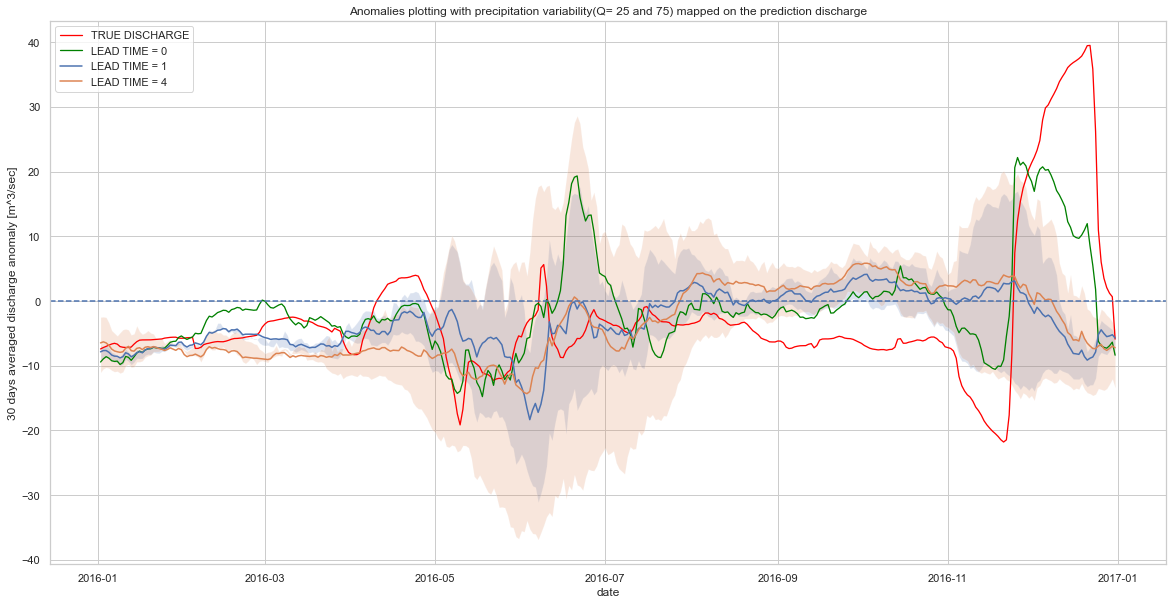

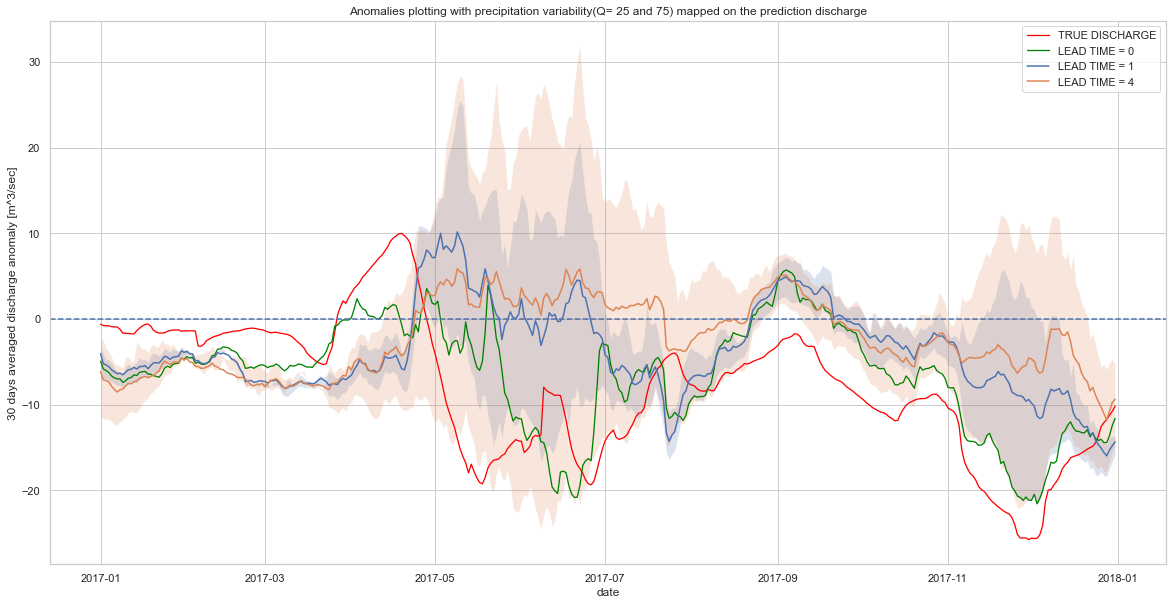

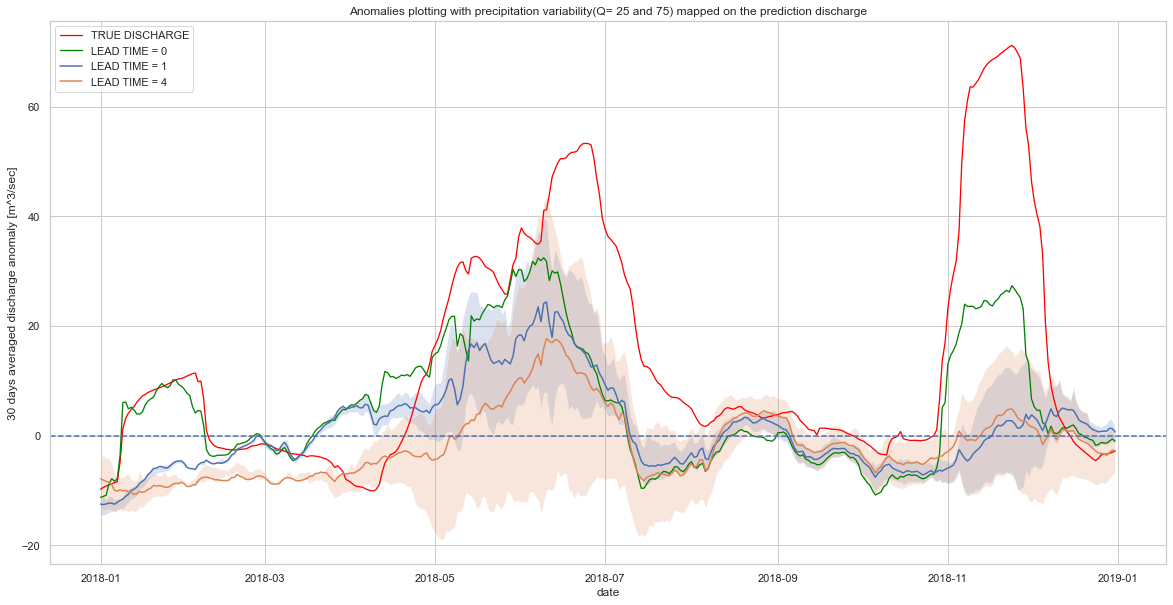

In [78]:
a2=compute_anomalies(climatologies2, predictions2)
a2['split']=predictions2.split
plot_anomalies(a2)

# C) SVR 
## WITH SPATIAL STATISTICS AS INPUT

In [79]:
t_unit=30


#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-1,3,6)
epsilon_range=np.logspace(-3, -1, 5)
gamma_range=np.logspace(-5,-2, 8)

#n_range = [17, 50, 200]

#do not enlarge t_range for now
t_range=[12]
t_length=t_range[0]
n_splits=5
test_size=365

Fitting 1 folds for each of 240 candidates, totalling 240 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 240 candidates, totalling 240 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 240 candidates, totalling 240 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 240 candidates, totalling 240 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 240 candidates, totalling 240 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"



C3=0.6309573444801934
eps3=0.003727593720314938
gamma3=0.0031622776601683794


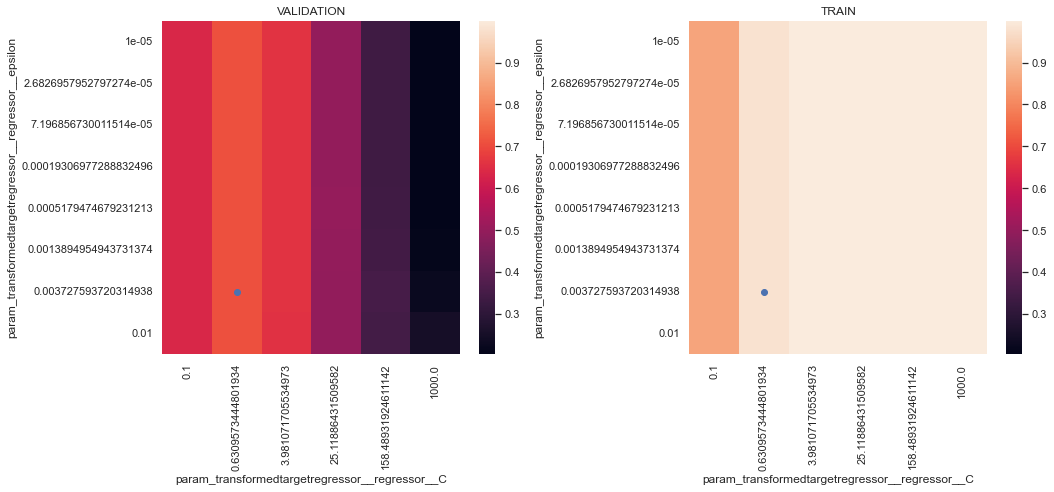

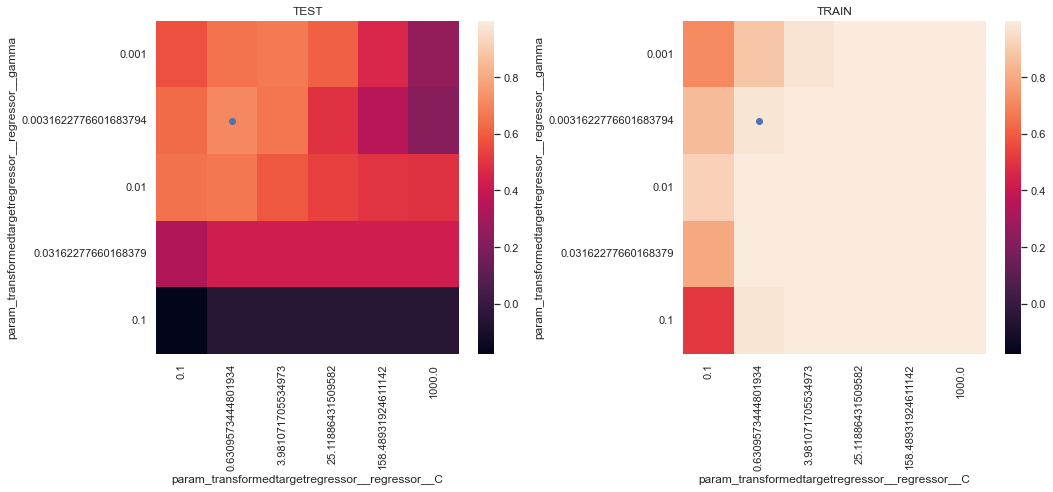

In [80]:
C3, eps3,gamma3 = SVR_nested_CV_gridsearch(daily_input_stat, C_range,gamma_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C3={C3}')
print(f'eps3={eps3}')
print(f'gamma3={gamma3}')


C3=0.5994842503189409
eps3=0.001

C3=0.5994842503189409
eps3=0.001

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [81]:
radius_for_ensemble = 1
predictions3 = nested_CV_SVR_predict(daily_input_stat, C3, eps3,gamma3, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

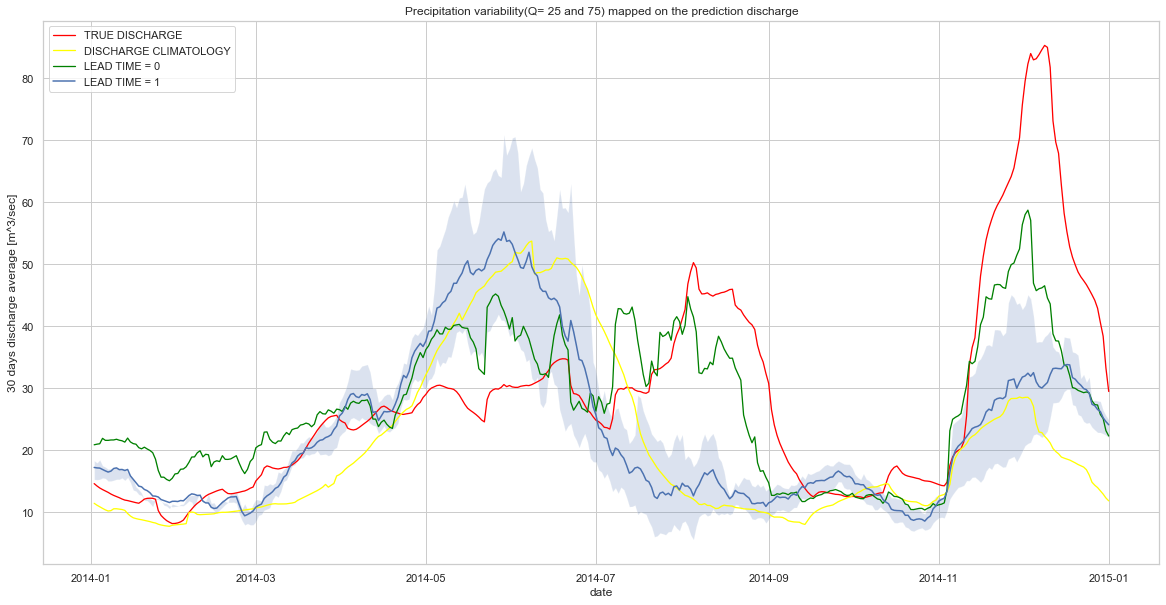

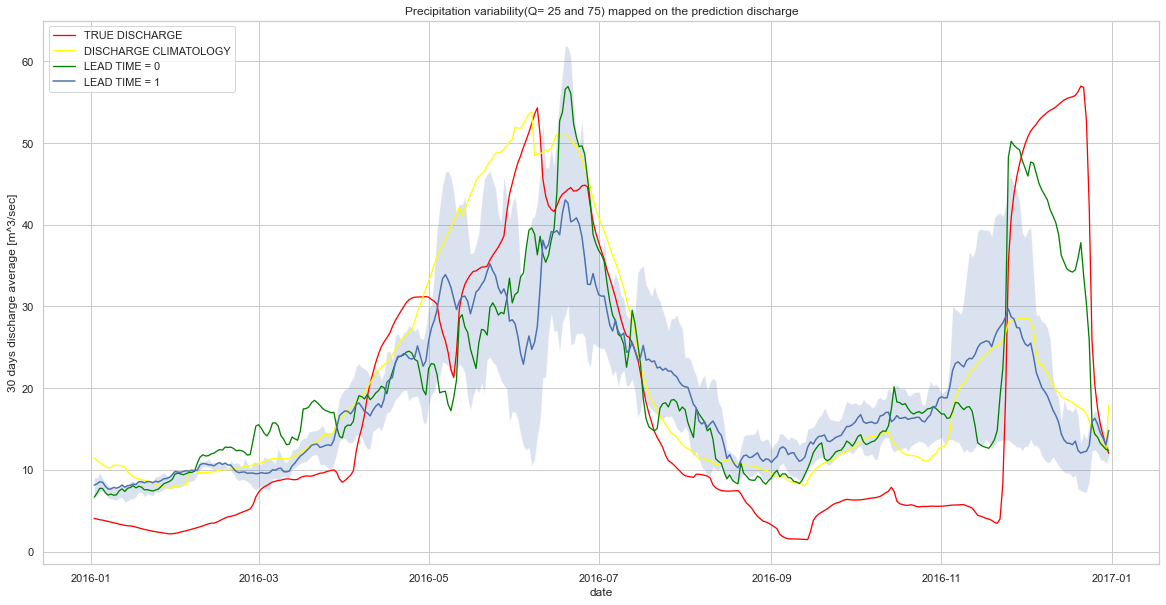

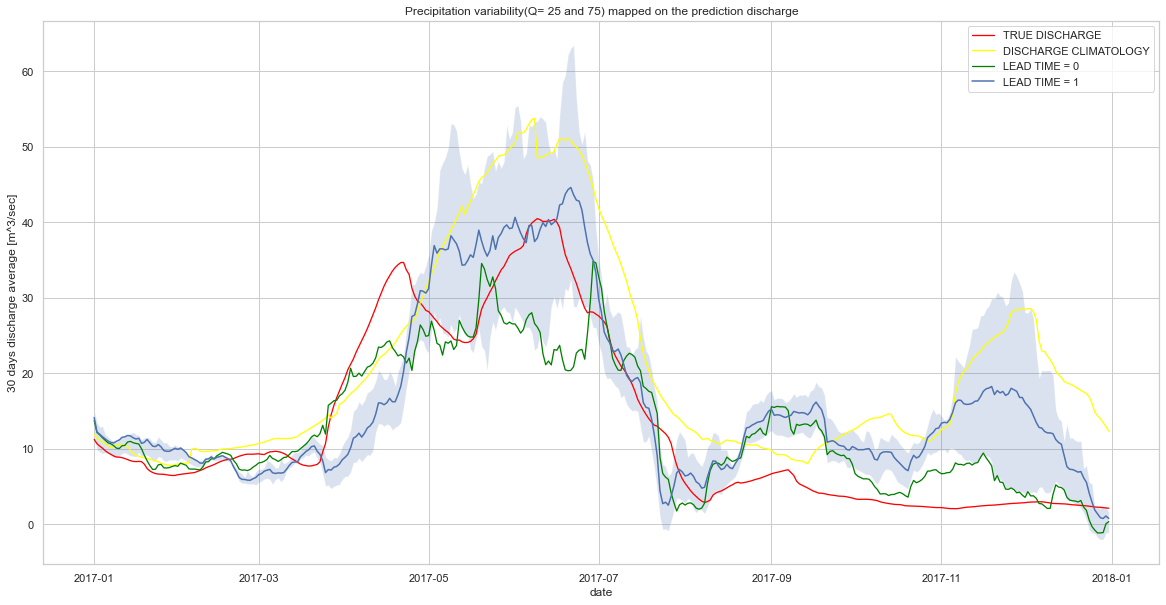

In [82]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions3)

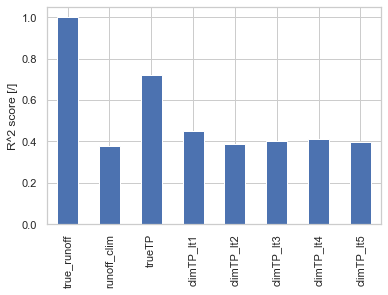

In [83]:
r2_STATS= evaluate_prediction(predictions3)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [85]:
predictions_for_clim3 = classic_CV_SVR_predict(daily_input_stat, C3, eps3,gamma3, t_length,t_unit, n_splits)

In [86]:
climatologies3 =predictions_for_clim3.groupby(by=predictions_for_clim3.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies3['doty']=climatologies3.index


climatologies3=climatologies

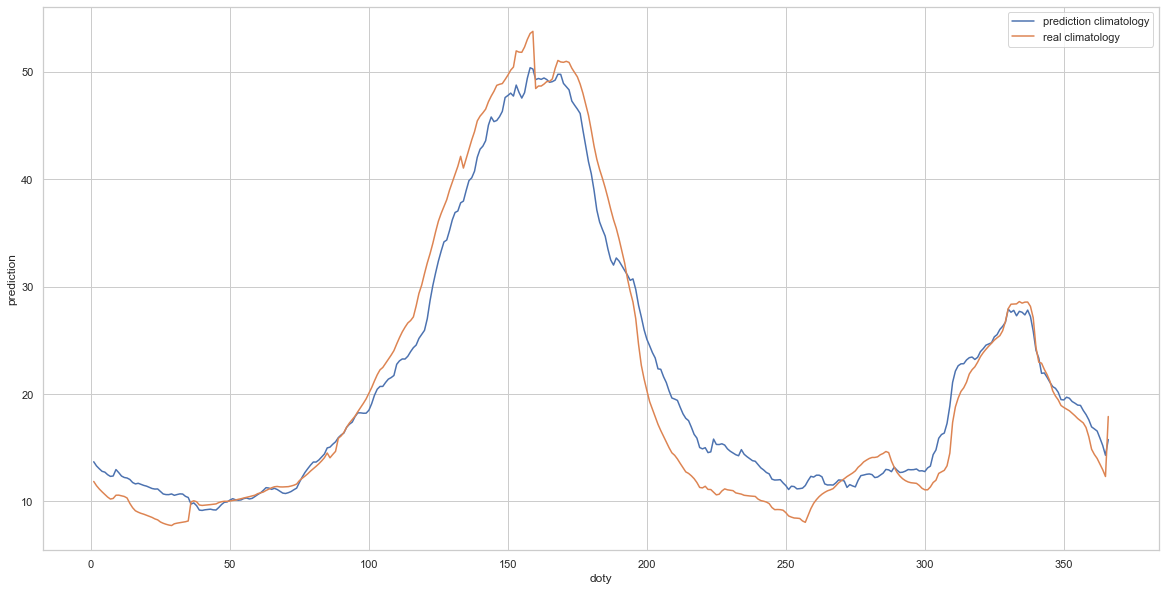

In [87]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies3,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies3,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

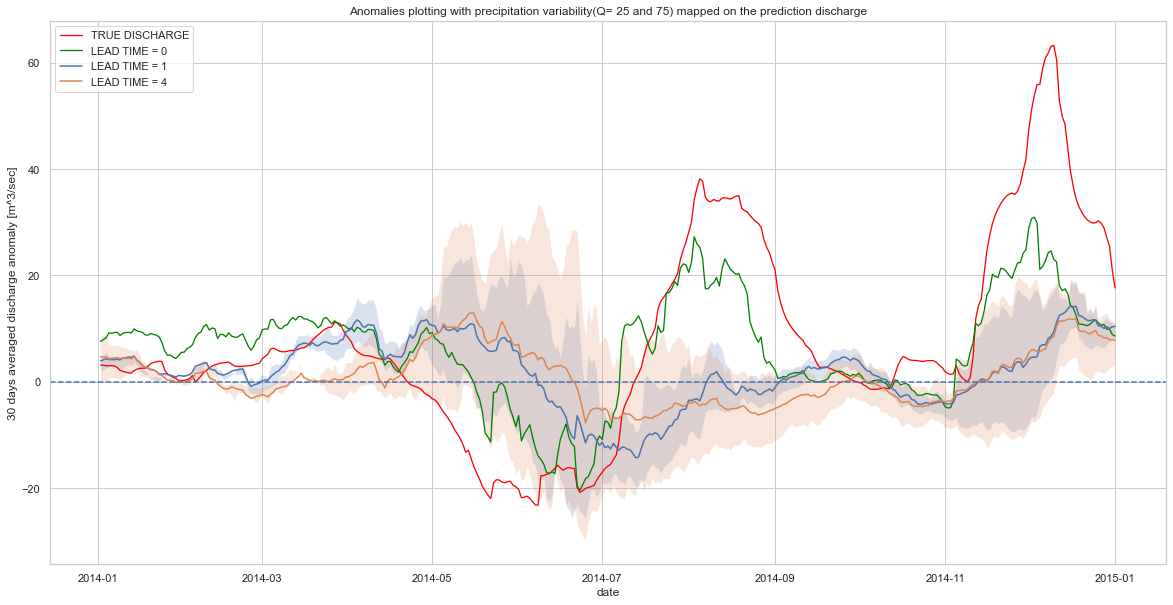

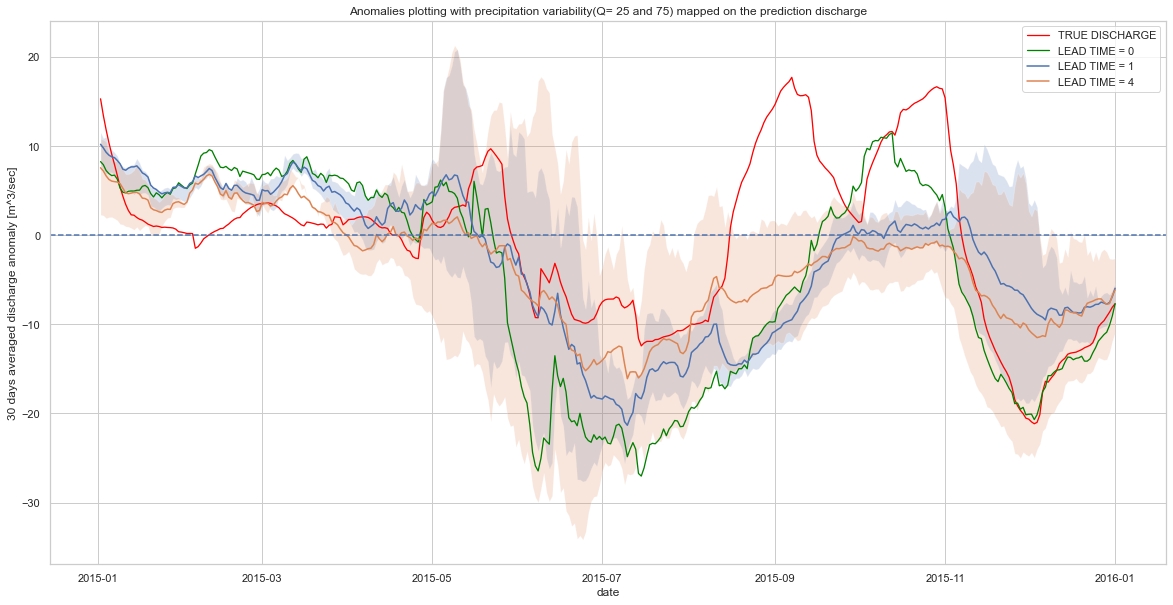

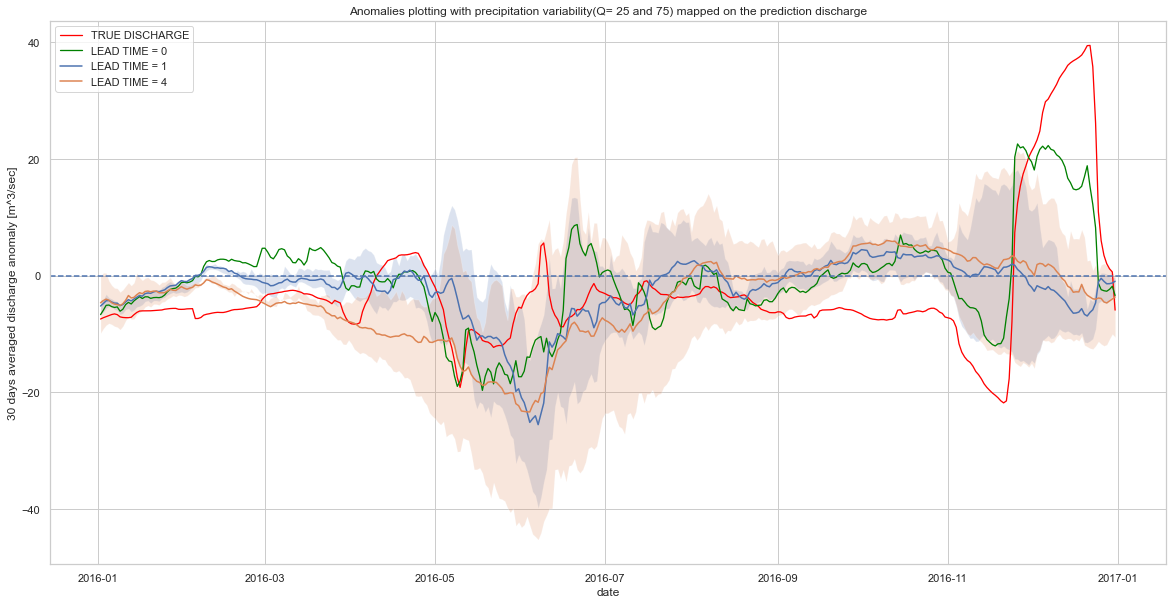

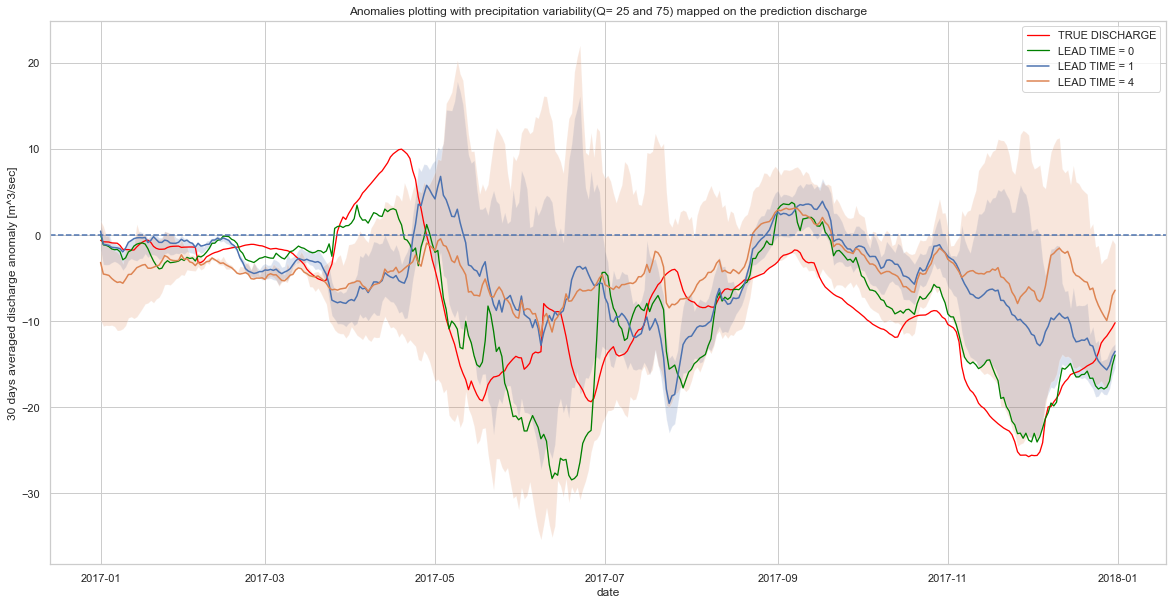

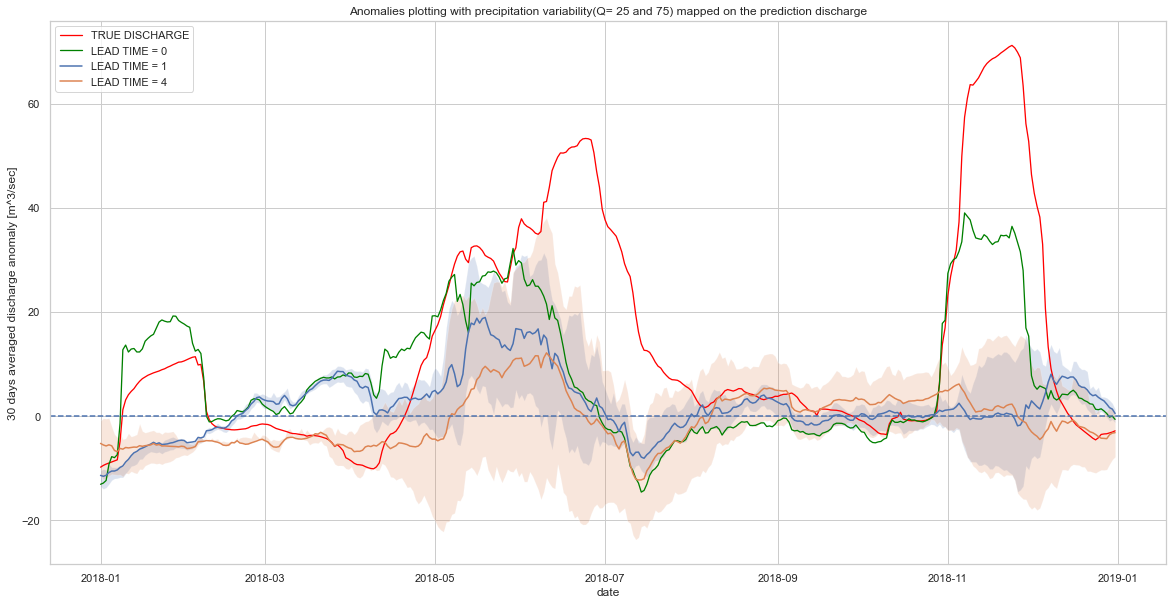

In [88]:
a3=compute_anomalies(climatologies3, predictions3)
a3['split']=predictions3.split

plot_anomalies(a3)

# D) SVR 
## WITH SPATIAL AVERAGE AS INPUT

In [89]:
t_unit=30


#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-2,1,10)
epsilon_range=np.logspace(-4, -2, 5)
gamma_range=np.logspace(-5,-2, 6)

#n_range = [17, 50, 200]
#components_range = [5*4*36]
components_range2 = [int(4*30/t_unit*12)]

#do not enlarge t_range for now
t_range=[12]
t_length=t_range[0]
n_splits=5
test_size=365

Fitting 1 folds for each of 300 candidates, totalling 300 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 300 candidates, totalling 300 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 300 candidates, totalling 300 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 300 candidates, totalling 300 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 300 candidates, totalling 300 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"



C4=2.154434690031882
eps4=0.0031622776601683794
gamma4=0.01


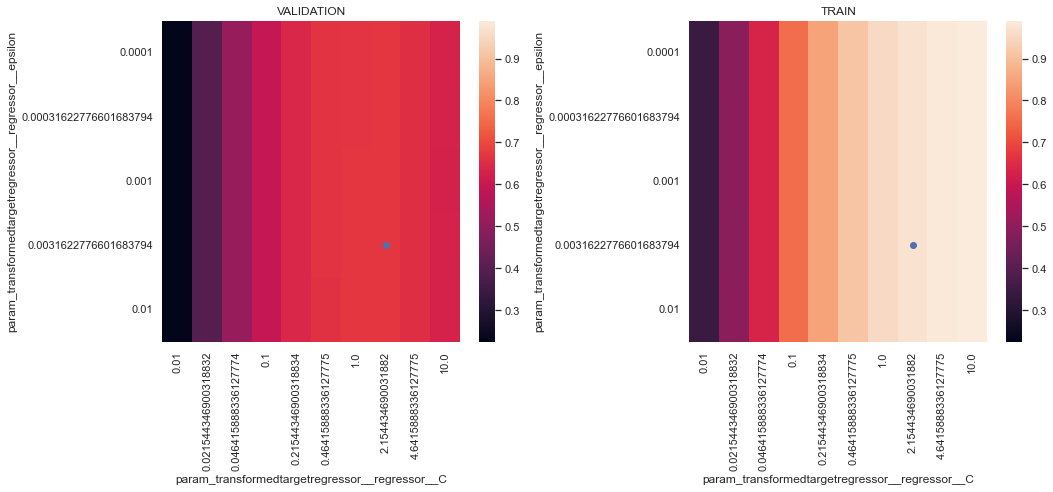

In [90]:
C4, eps4,gamma4 = SVR_nested_CV_gridsearch(daily_input_TPE, C_range,epsilon_range,gamma_range, t_range,t_unit,n_splits,test_size)
print(f'C4={C4}')
print(f'eps4={eps4}')
print(f'gamma4={gamma4}')


In [99]:
t_unit=30


#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-1,1,10)
epsilon_range=np.logspace(-4, -2, 5)
gamma_range=np.logspace(-3,-1, 5)

#n_range = [17, 50, 200]
#components_range = [5*4*36]
components_range2 = [int(4*30/t_unit*12)]

#do not enlarge t_range for now
t_range=[12]
t_length=t_range[0]
n_splits=5
test_size=365

In [100]:
C4, eps4,gamma4 = SVR_nested_CV_gridsearch(daily_input_TPE, C_range,epsilon_range,gamma_range, t_range,t_unit,n_splits,test_size)
print(f'C4={C4}')
print(f'eps4={eps4}')
print(f'gamma4={gamma4}')


Fitting 1 folds for each of 250 candidates, totalling 250 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 250 candidates, totalling 250 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 250 candidates, totalling 250 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 250 candidates, totalling 250 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 250 candidates, totalling 250 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"



C4=1.291549665014884
eps4=0.001
gamma4=0.01


C4=0.21544346900318834
eps4=0.01

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [101]:
radius_for_ensemble = 1
predictions4 = nested_CV_SVR_predict(daily_input_stat, C4, eps4,gamma4, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

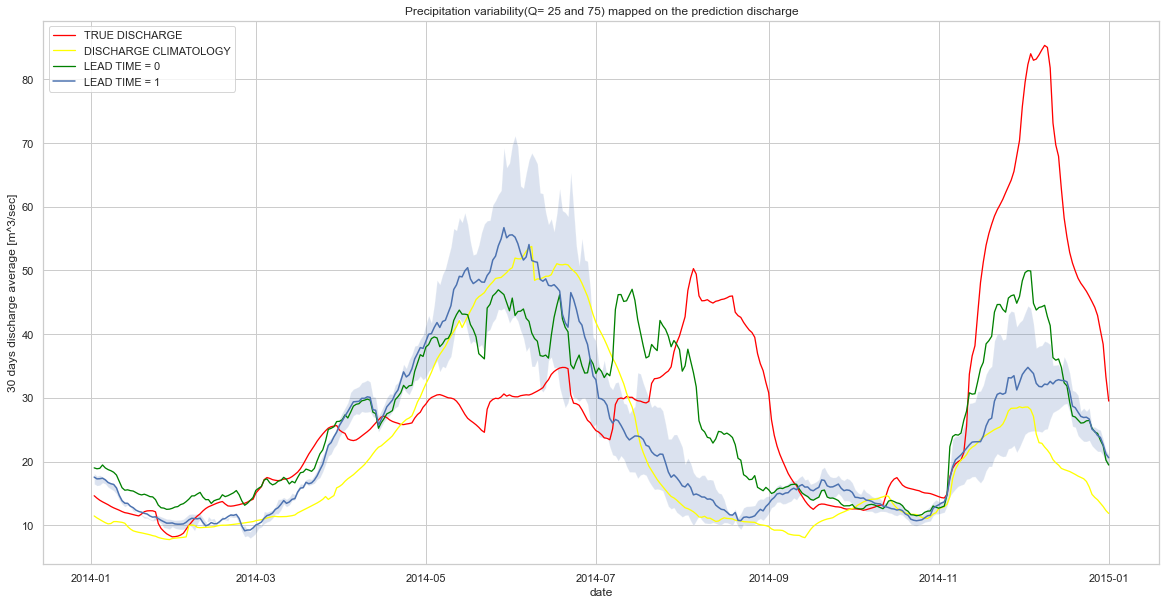

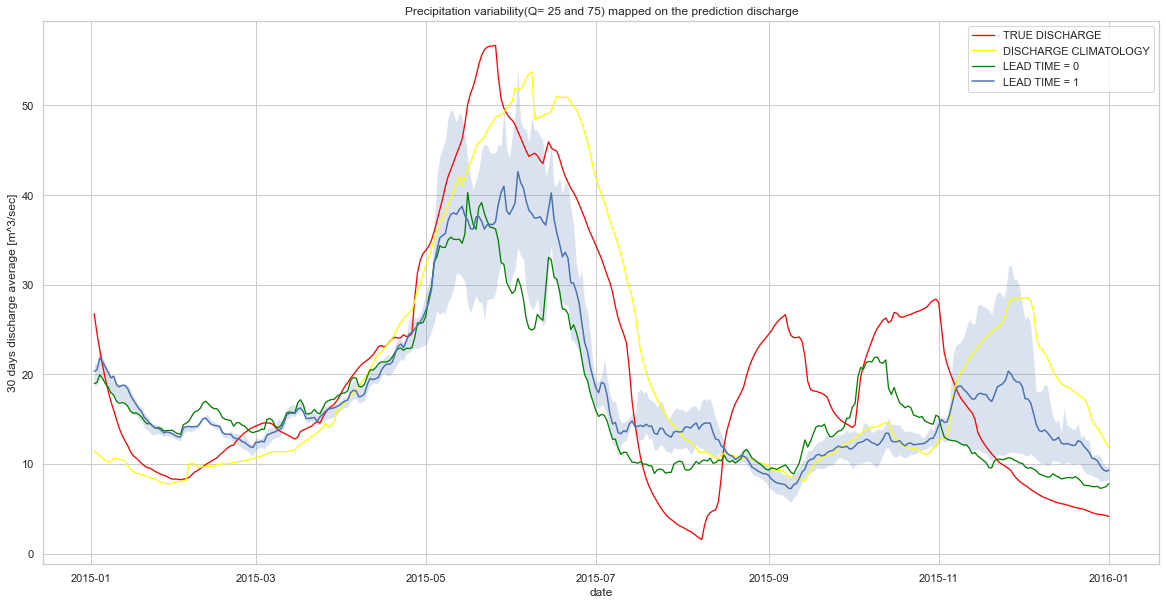

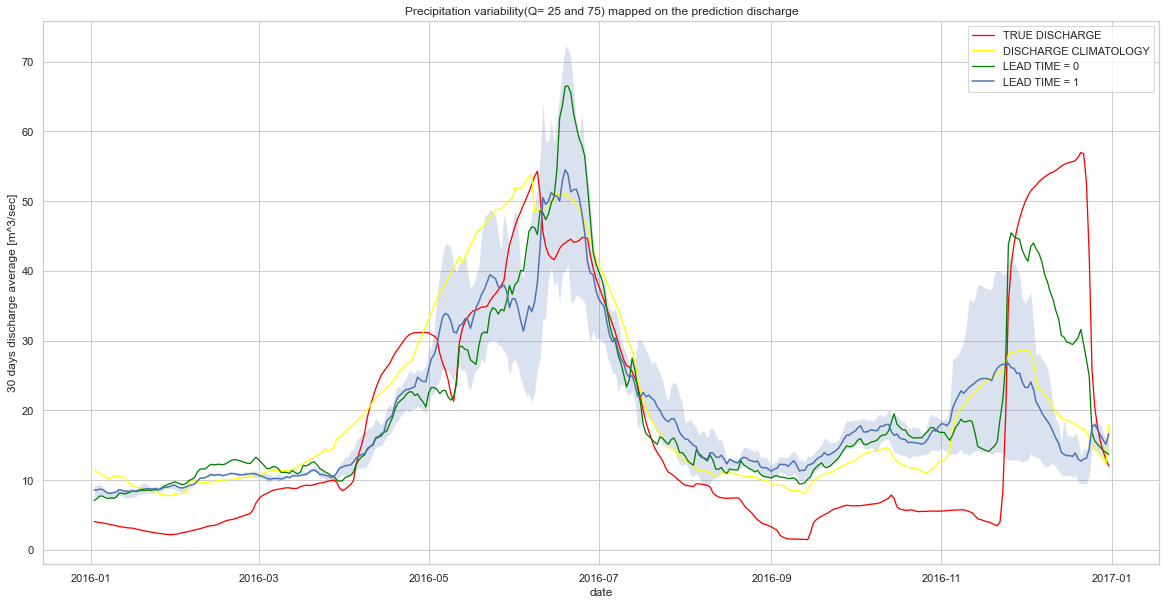

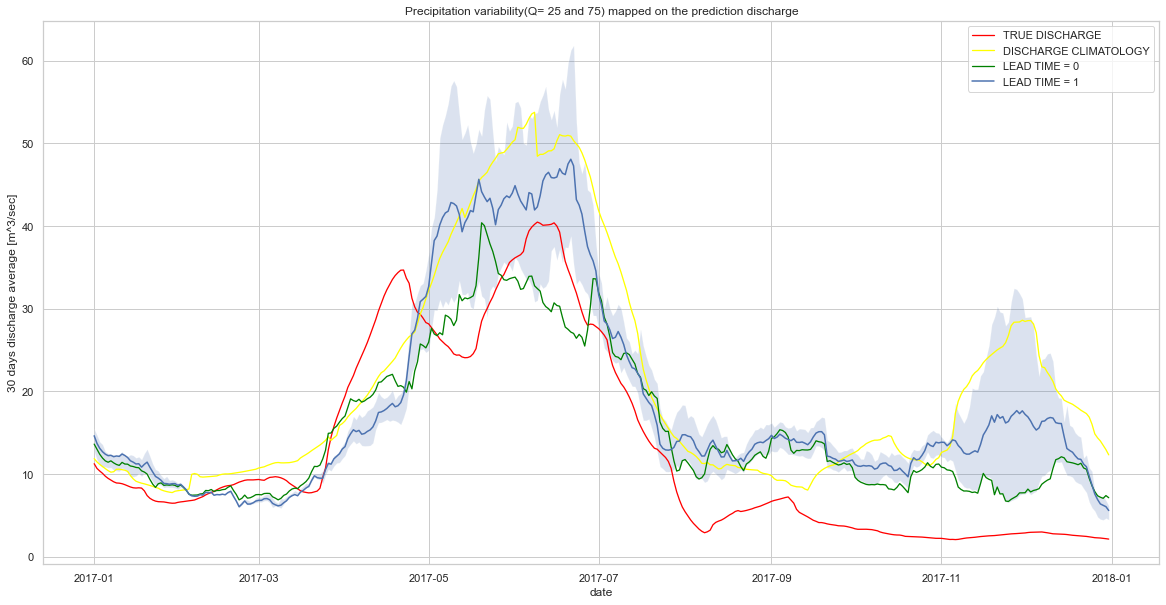

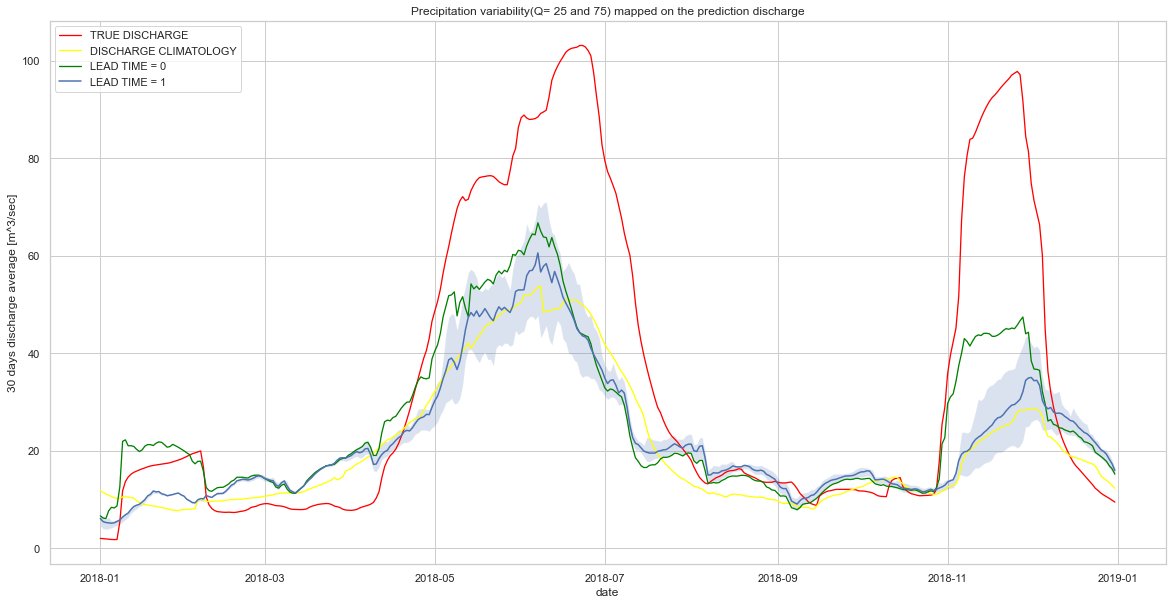

In [102]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions4)

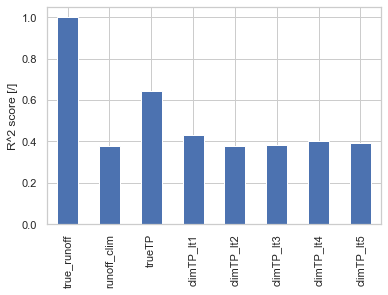

In [103]:
r2_TPE = evaluate_prediction(predictions4)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

predictions_for_clim4 = classic_CV_SVR_predict(daily_input_stat, C4, eps4,gamma4, t_length,t_unit, n_splits)

climatologies4 =predictions_for_clim4.groupby(by=predictions_for_clim4.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies4['doty']=climatologies4.index


In [104]:
climatologies4=climatologies

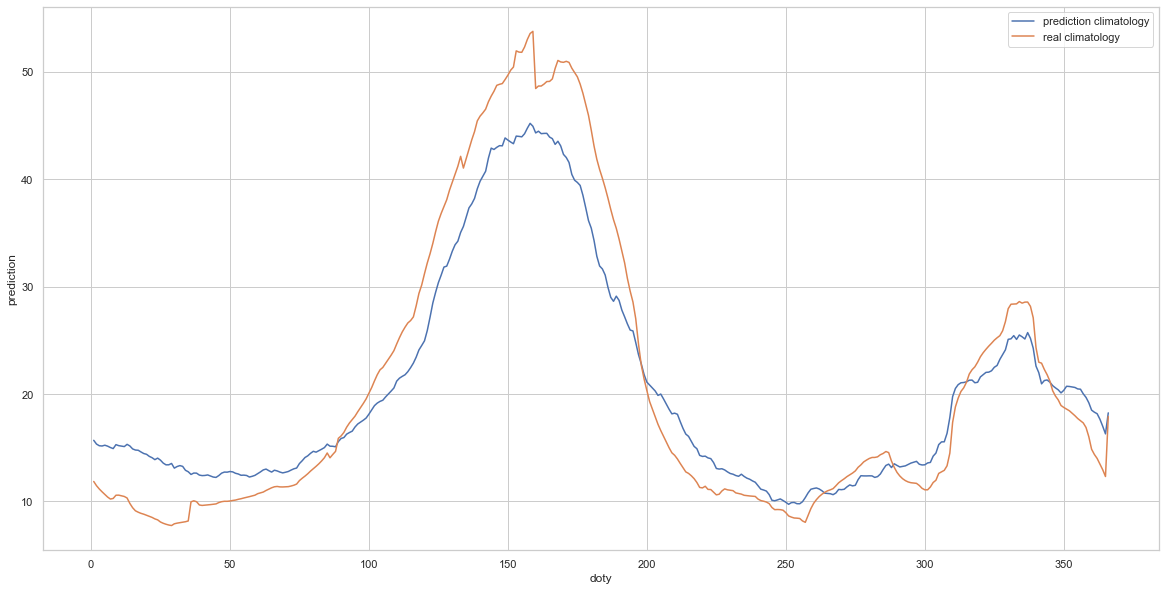

In [105]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies4,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies4,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

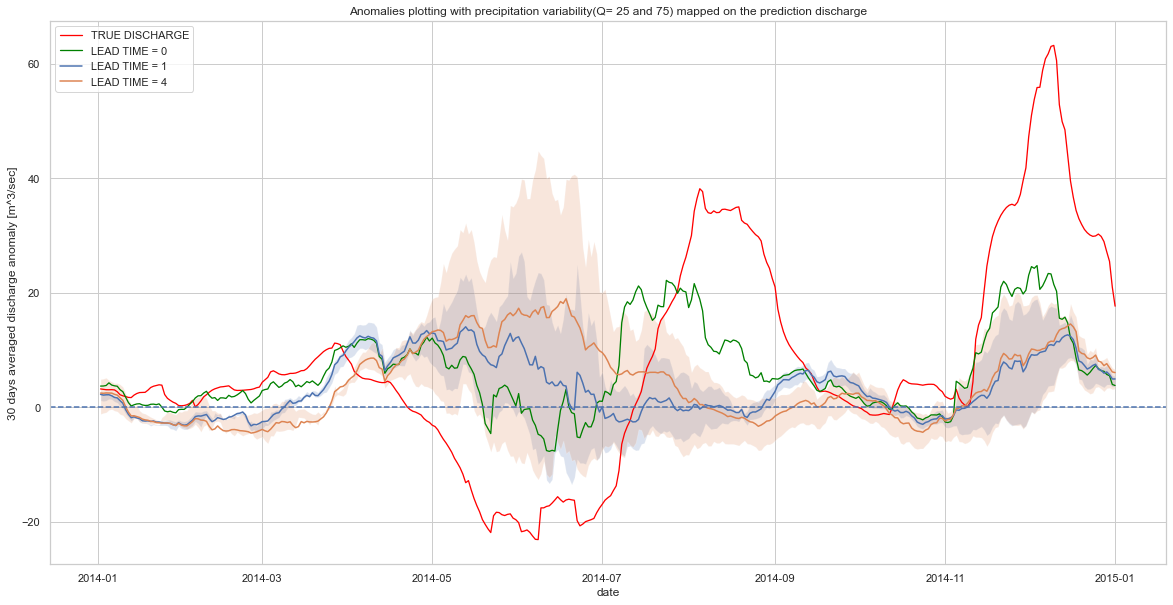

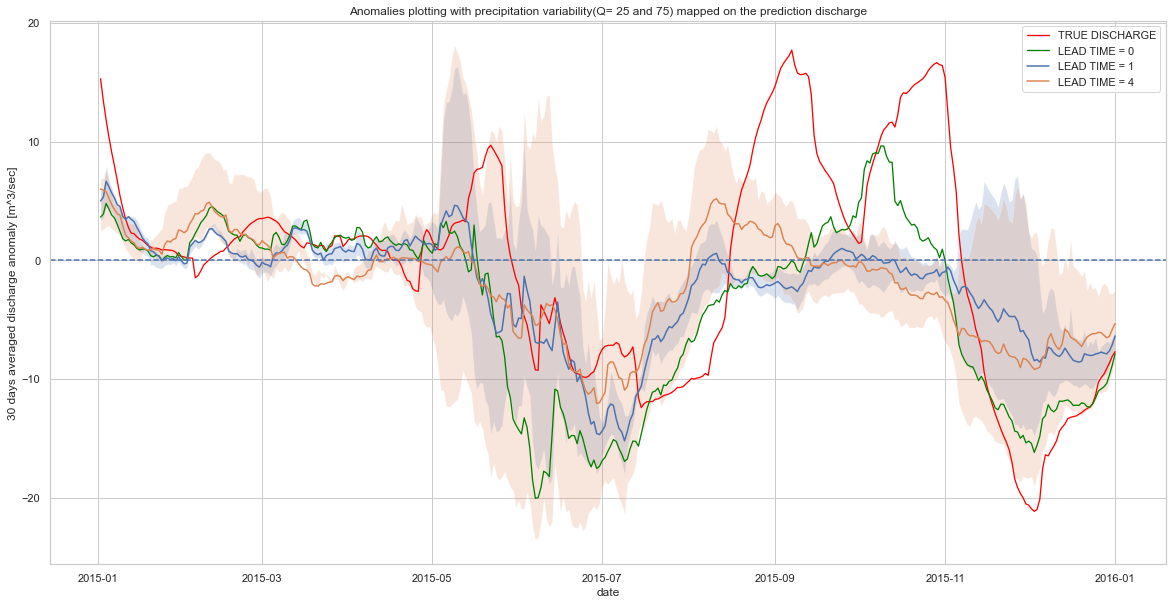

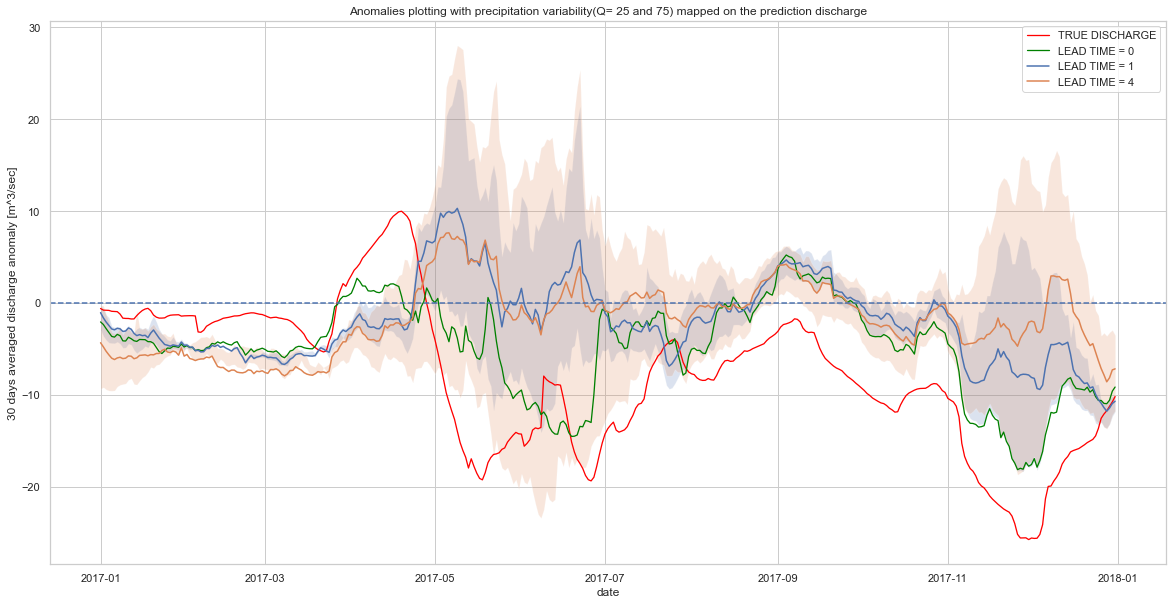

In [106]:
a4=compute_anomalies(climatologies4, predictions4)
a4['split']=predictions4.split
plot_anomalies(a4)

# COMPARE RESULTS

In [107]:
results = pd.concat([r2_PCA180,r2_PCA36,r2_STATS,r2_TPE],axis=1)
results.columns=['A) PCA(180)','B) PCA(36)','C) TPE_STATS','D) TPE_AVG']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

Text(0, 0.5, 'r^2 [/]')

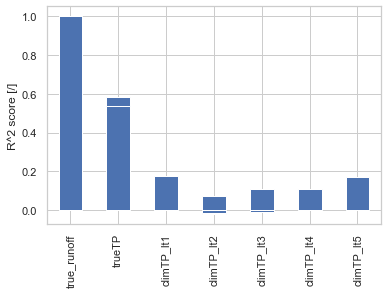

In [108]:
r2_TPE_an = evaluate_prediction(a4)
r2_STATS_an= evaluate_prediction(a3)
r2_PCA36_an = evaluate_prediction(a2)
r2_PCA180_an = evaluate_prediction(a)

Text(0, 0.5, 'r^2 [/]')

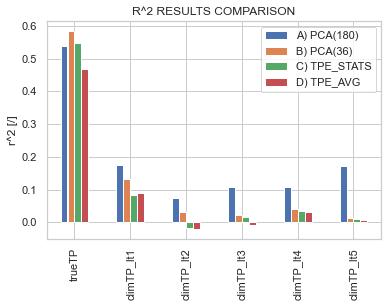

In [109]:
results = pd.concat([r2_PCA180_an,r2_PCA36_an,r2_STATS_an,r2_TPE_an],axis=1)
results.columns=['A) PCA(180)','B) PCA(36)','C) TPE_STATS','D) TPE_AVG']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

## CONCLUSION

By comparing the results with a similar analysis exectuted without tuning the gamma parameter, it is possible to state that no improvement up to negligible improvement is seen when adding the gamma parameter to hypertuning set.
For this reason, we went on without including this parameter in the hypertuning set.